# Demo: Reject Learner for Triage in Classification

## Learning objectives
- Understand how to use the reject learner for automatic triage in classification tasks.
- Learn to combine reject predictions with factual explanations for uncertain cases.

## Time to run
~3-5 min

In [10]:
# Import required libraries
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from calibrated_explanations import CalibratedExplainer, __version__
print("Calibrated Explanations version:", __version__)

Calibrated Explanations version: v0.9.1


In [11]:
# Load and prepare data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_proper, X_cal, y_proper, y_cal = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [12]:
# Train model
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_proper, y_proper)

RandomForestClassifier(n_estimators=10, random_state=42)

In [13]:
# Calibrate explainer
ce = CalibratedExplainer(model, X_cal, y_cal)

In [14]:
# Initialize reject learner
ce.initialize_reject_learner()

ConformalClassifier(fitted=True, mondrian=True)

In [15]:
# Predict reject on test instances
reject_predictions = ce.predict_reject(X_test)
print("Reject predictions for first 10 instances:", reject_predictions[:10])

Reject predictions for first 10 instances: (array([ True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False]), 0.05643564356435648, 0.11403508771929827)


In [16]:
# Triage: for rejected instances, explain; for confident ones, auto-decide
for i in range(len(y_test)):  # Check first 5 instances
    if reject_predictions[0][i] > 0.5:  # Assuming reject_predictions[i] is [reject_prob, not_reject_prob]
        print(f"Instance {i}: Rejected - requires human review", end="")
        # Explain the rejected instance
        explanations = ce.explain_factual(X_test[i:i+1])
        print(f"  Probability: {explanations[0].prediction['predict']:.3f}")
    else:
        print(f"Instance {i}: Auto-decided - confident prediction", end="")
        pred = ce.predict_proba(X_test[i:i+1])
        print(f"  Probability: {pred[0][1]:.3f}")  # Assuming binary, positive class

Instance 0: Rejected - requires human review  Probability: 0.860
Instance 1: Auto-decided - confident prediction  Probability: 0.026
Instance 2: Auto-decided - confident prediction

  Probability: 0.026
Instance 3: Auto-decided - confident prediction  Probability: 0.960
Instance 4: Auto-decided - confident prediction  Probability: 0.960
Instance 5: Auto-decided - confident prediction  Probability: 0.026
Instance 6: Auto-decided - confident prediction  Probability: 0.026
Instance 7: Auto-decided - confident prediction  Probability: 0.125
Instance 8: Auto-decided - confident prediction  Probability: 0.026
Instance 9: Rejected - requires human review  Probability: 0.847
Instance 10: Auto-decided - confident prediction  Probability: 0.847
Instance 11: Auto-decided - confident prediction  Probability: 0.026
Instance 12: Auto-decided - confident prediction  Probability: 0.960
Instance 13: Auto-decided - confident prediction  Probability: 0.125
Instance 14: Auto-decided - confident prediction  Probability: 0.860
Instance 15: Auto-decided - confident prediction  Probability: 0.026
Instance 16: Auto-decided - confident prediction  Probability: 0.960
Instance 17: Auto-decid

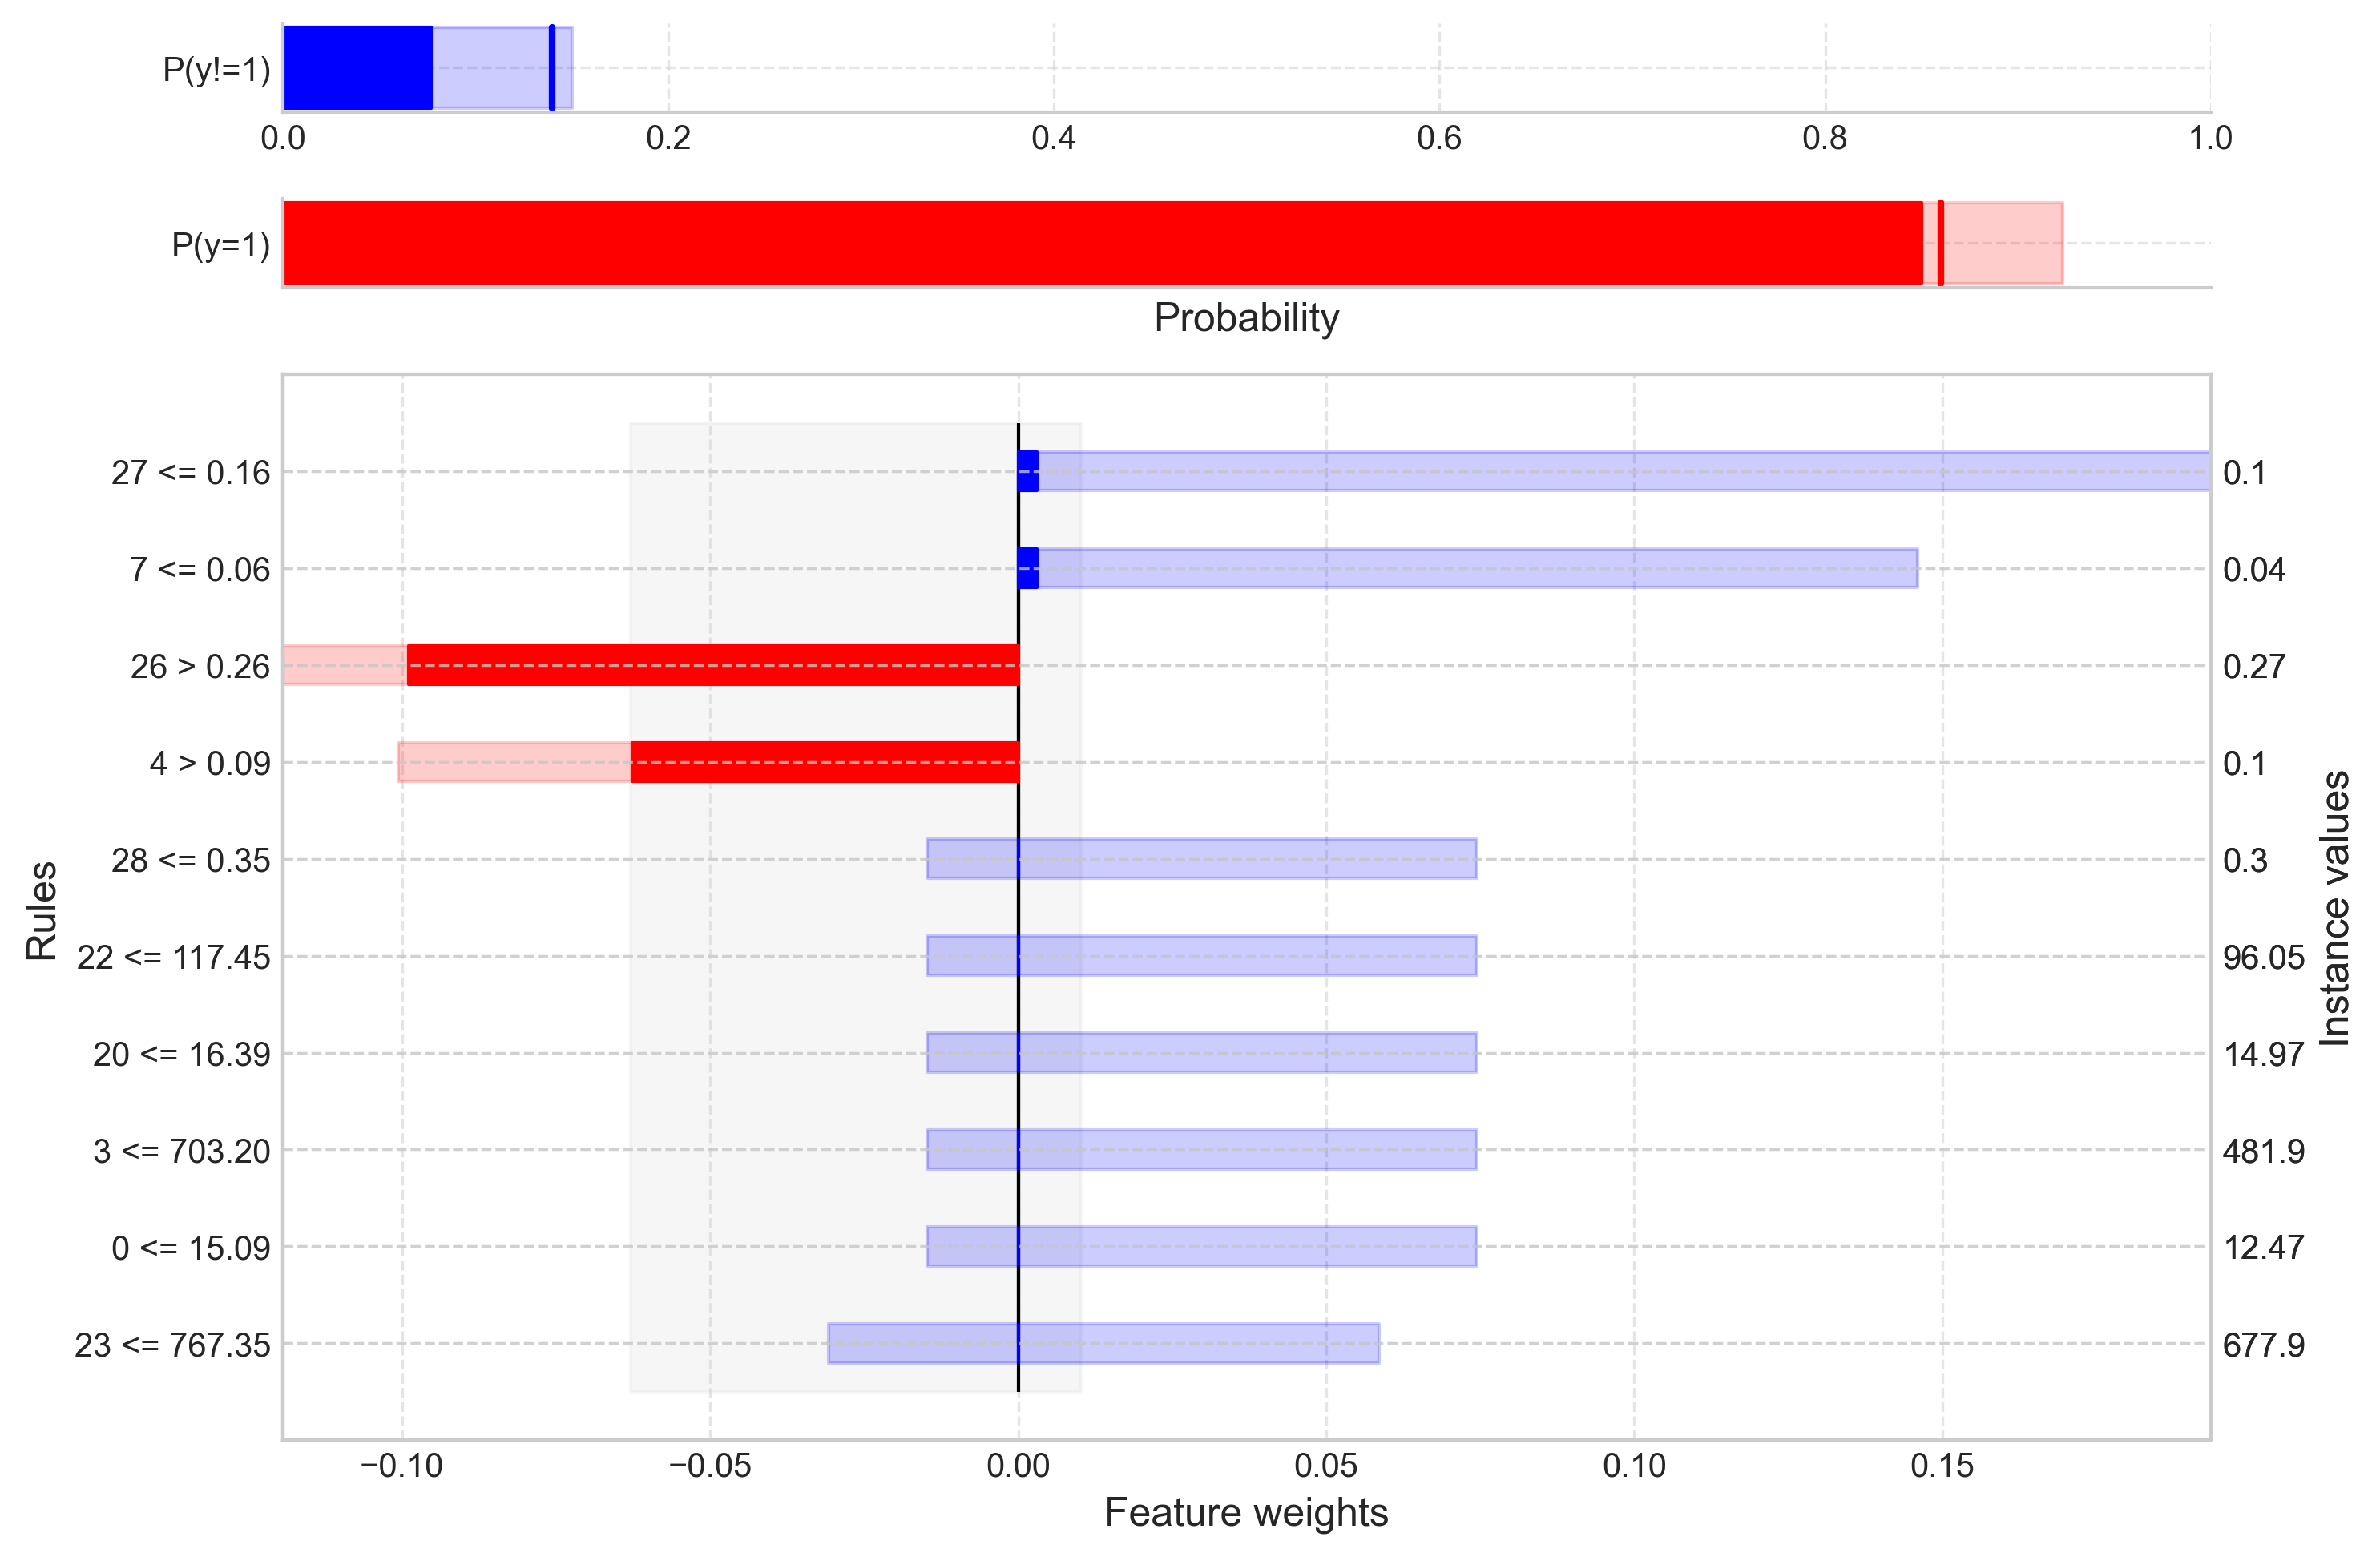

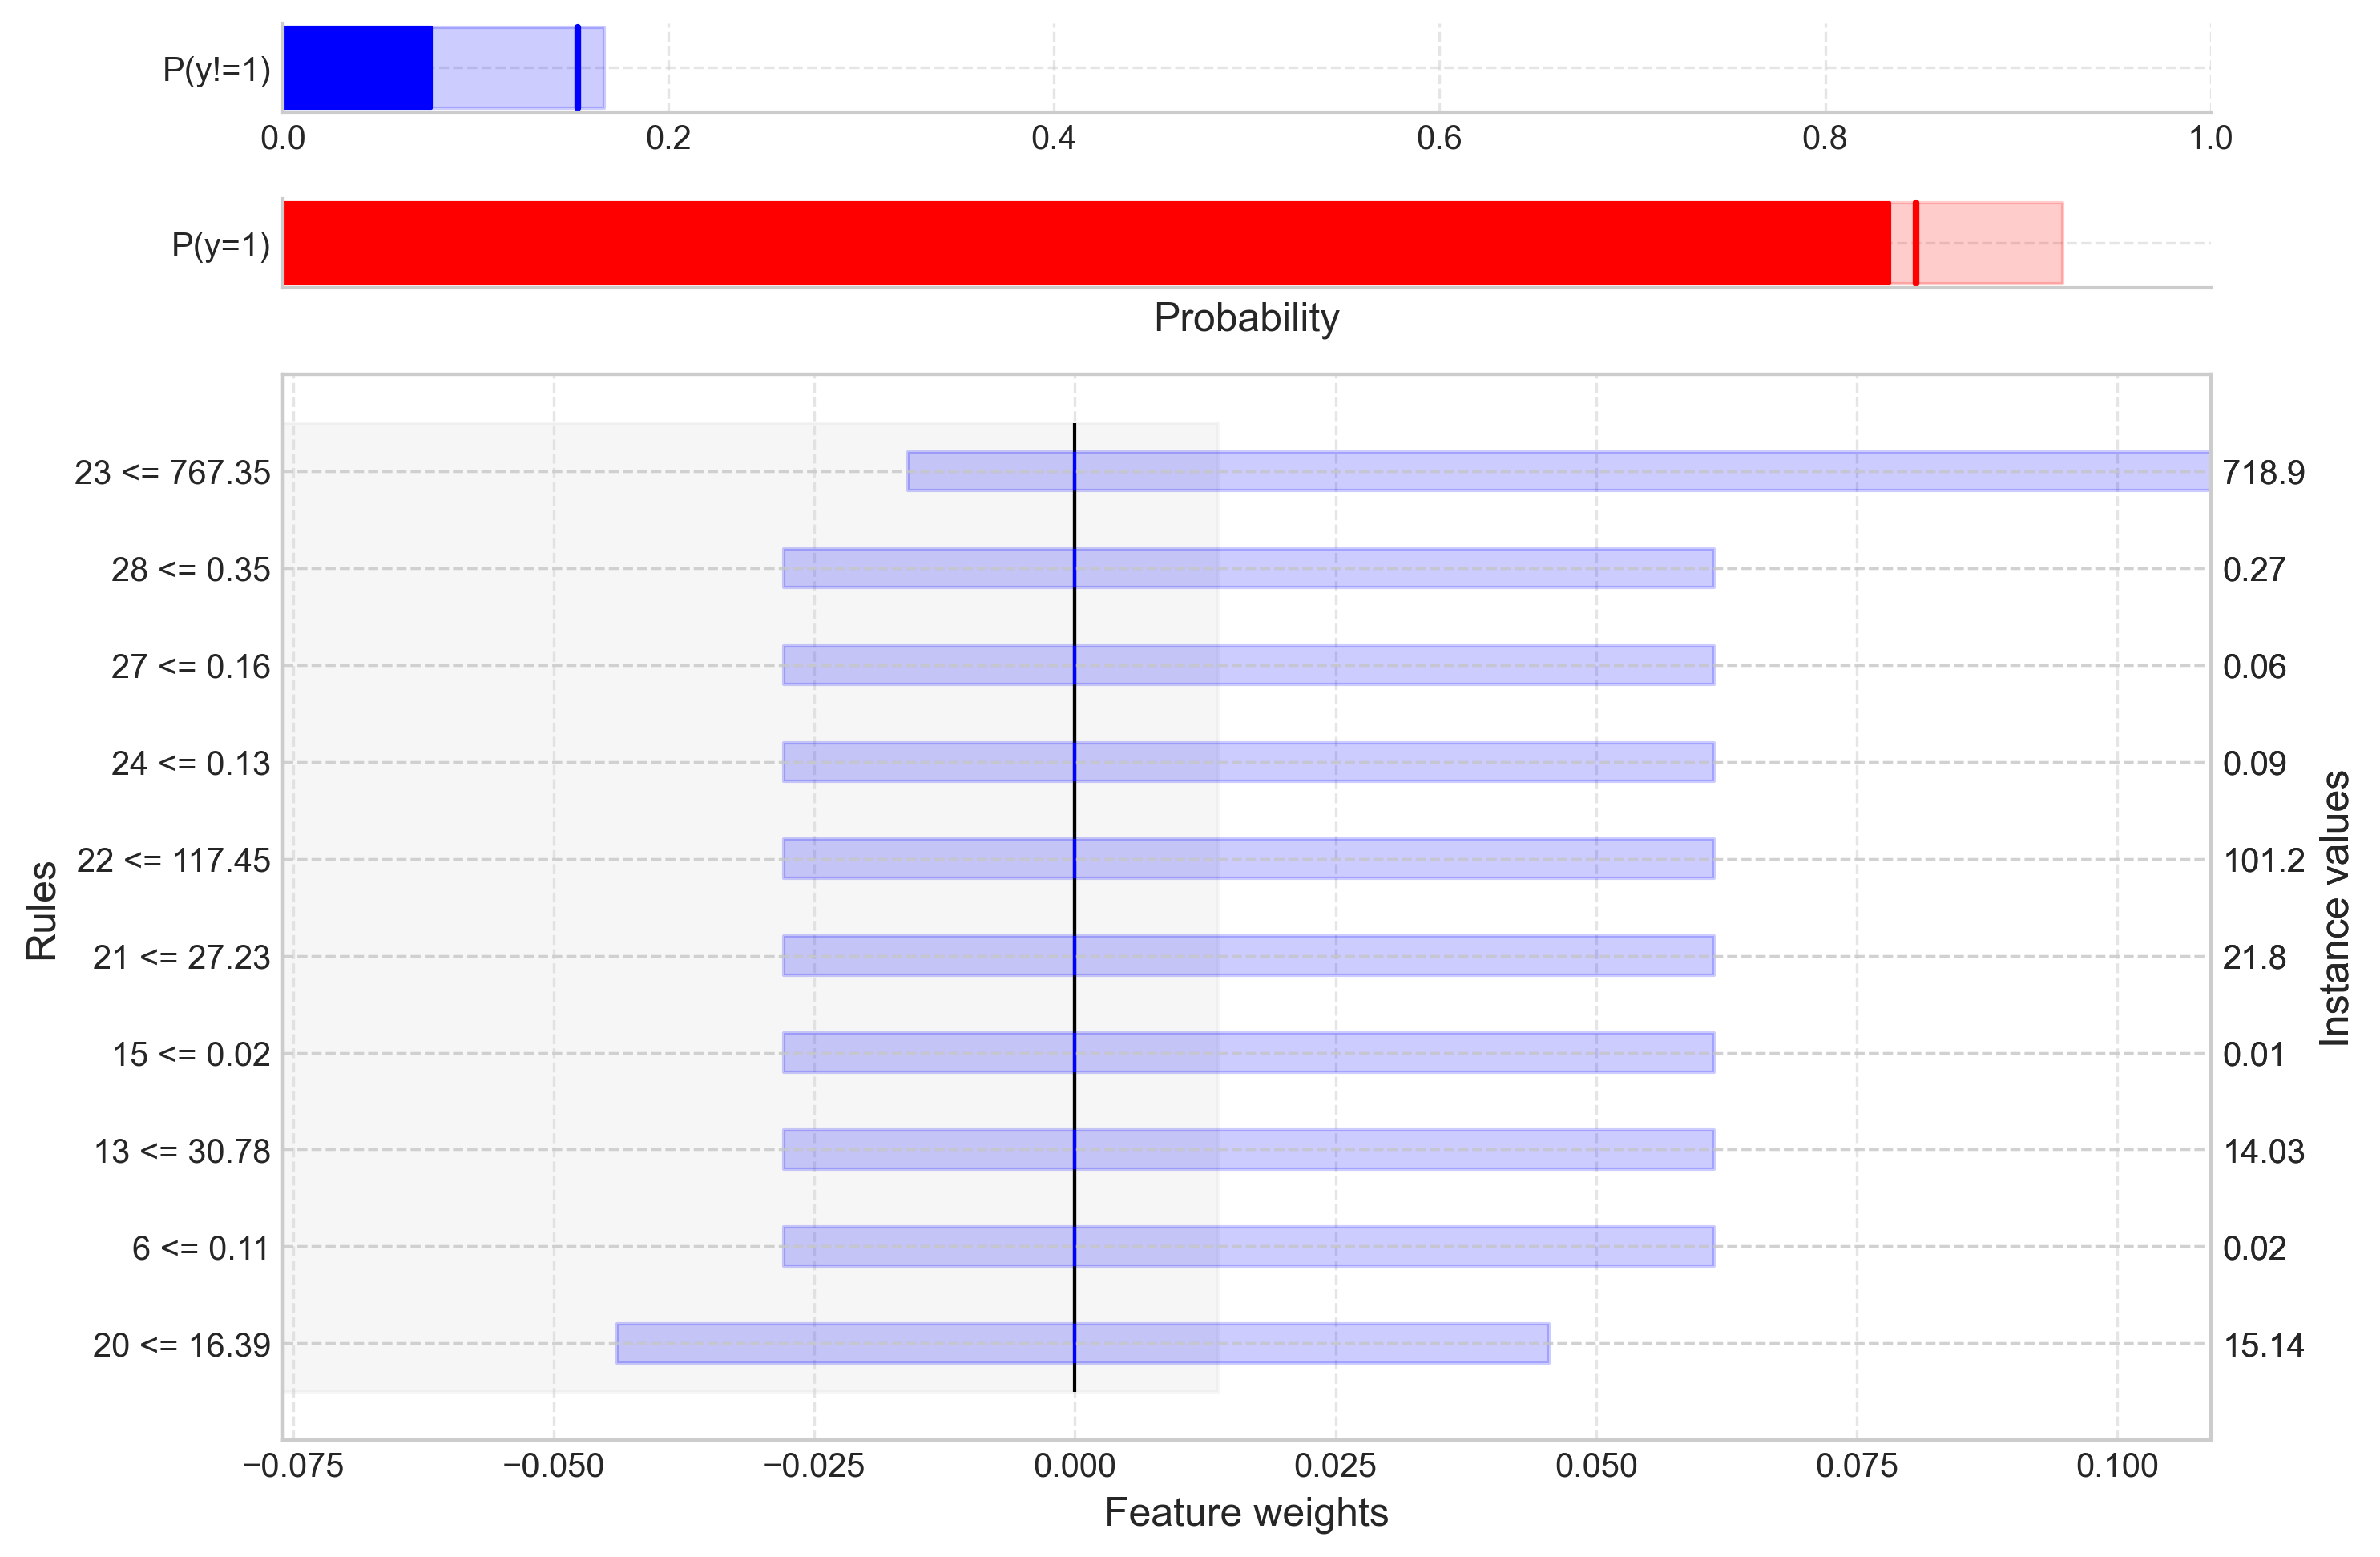

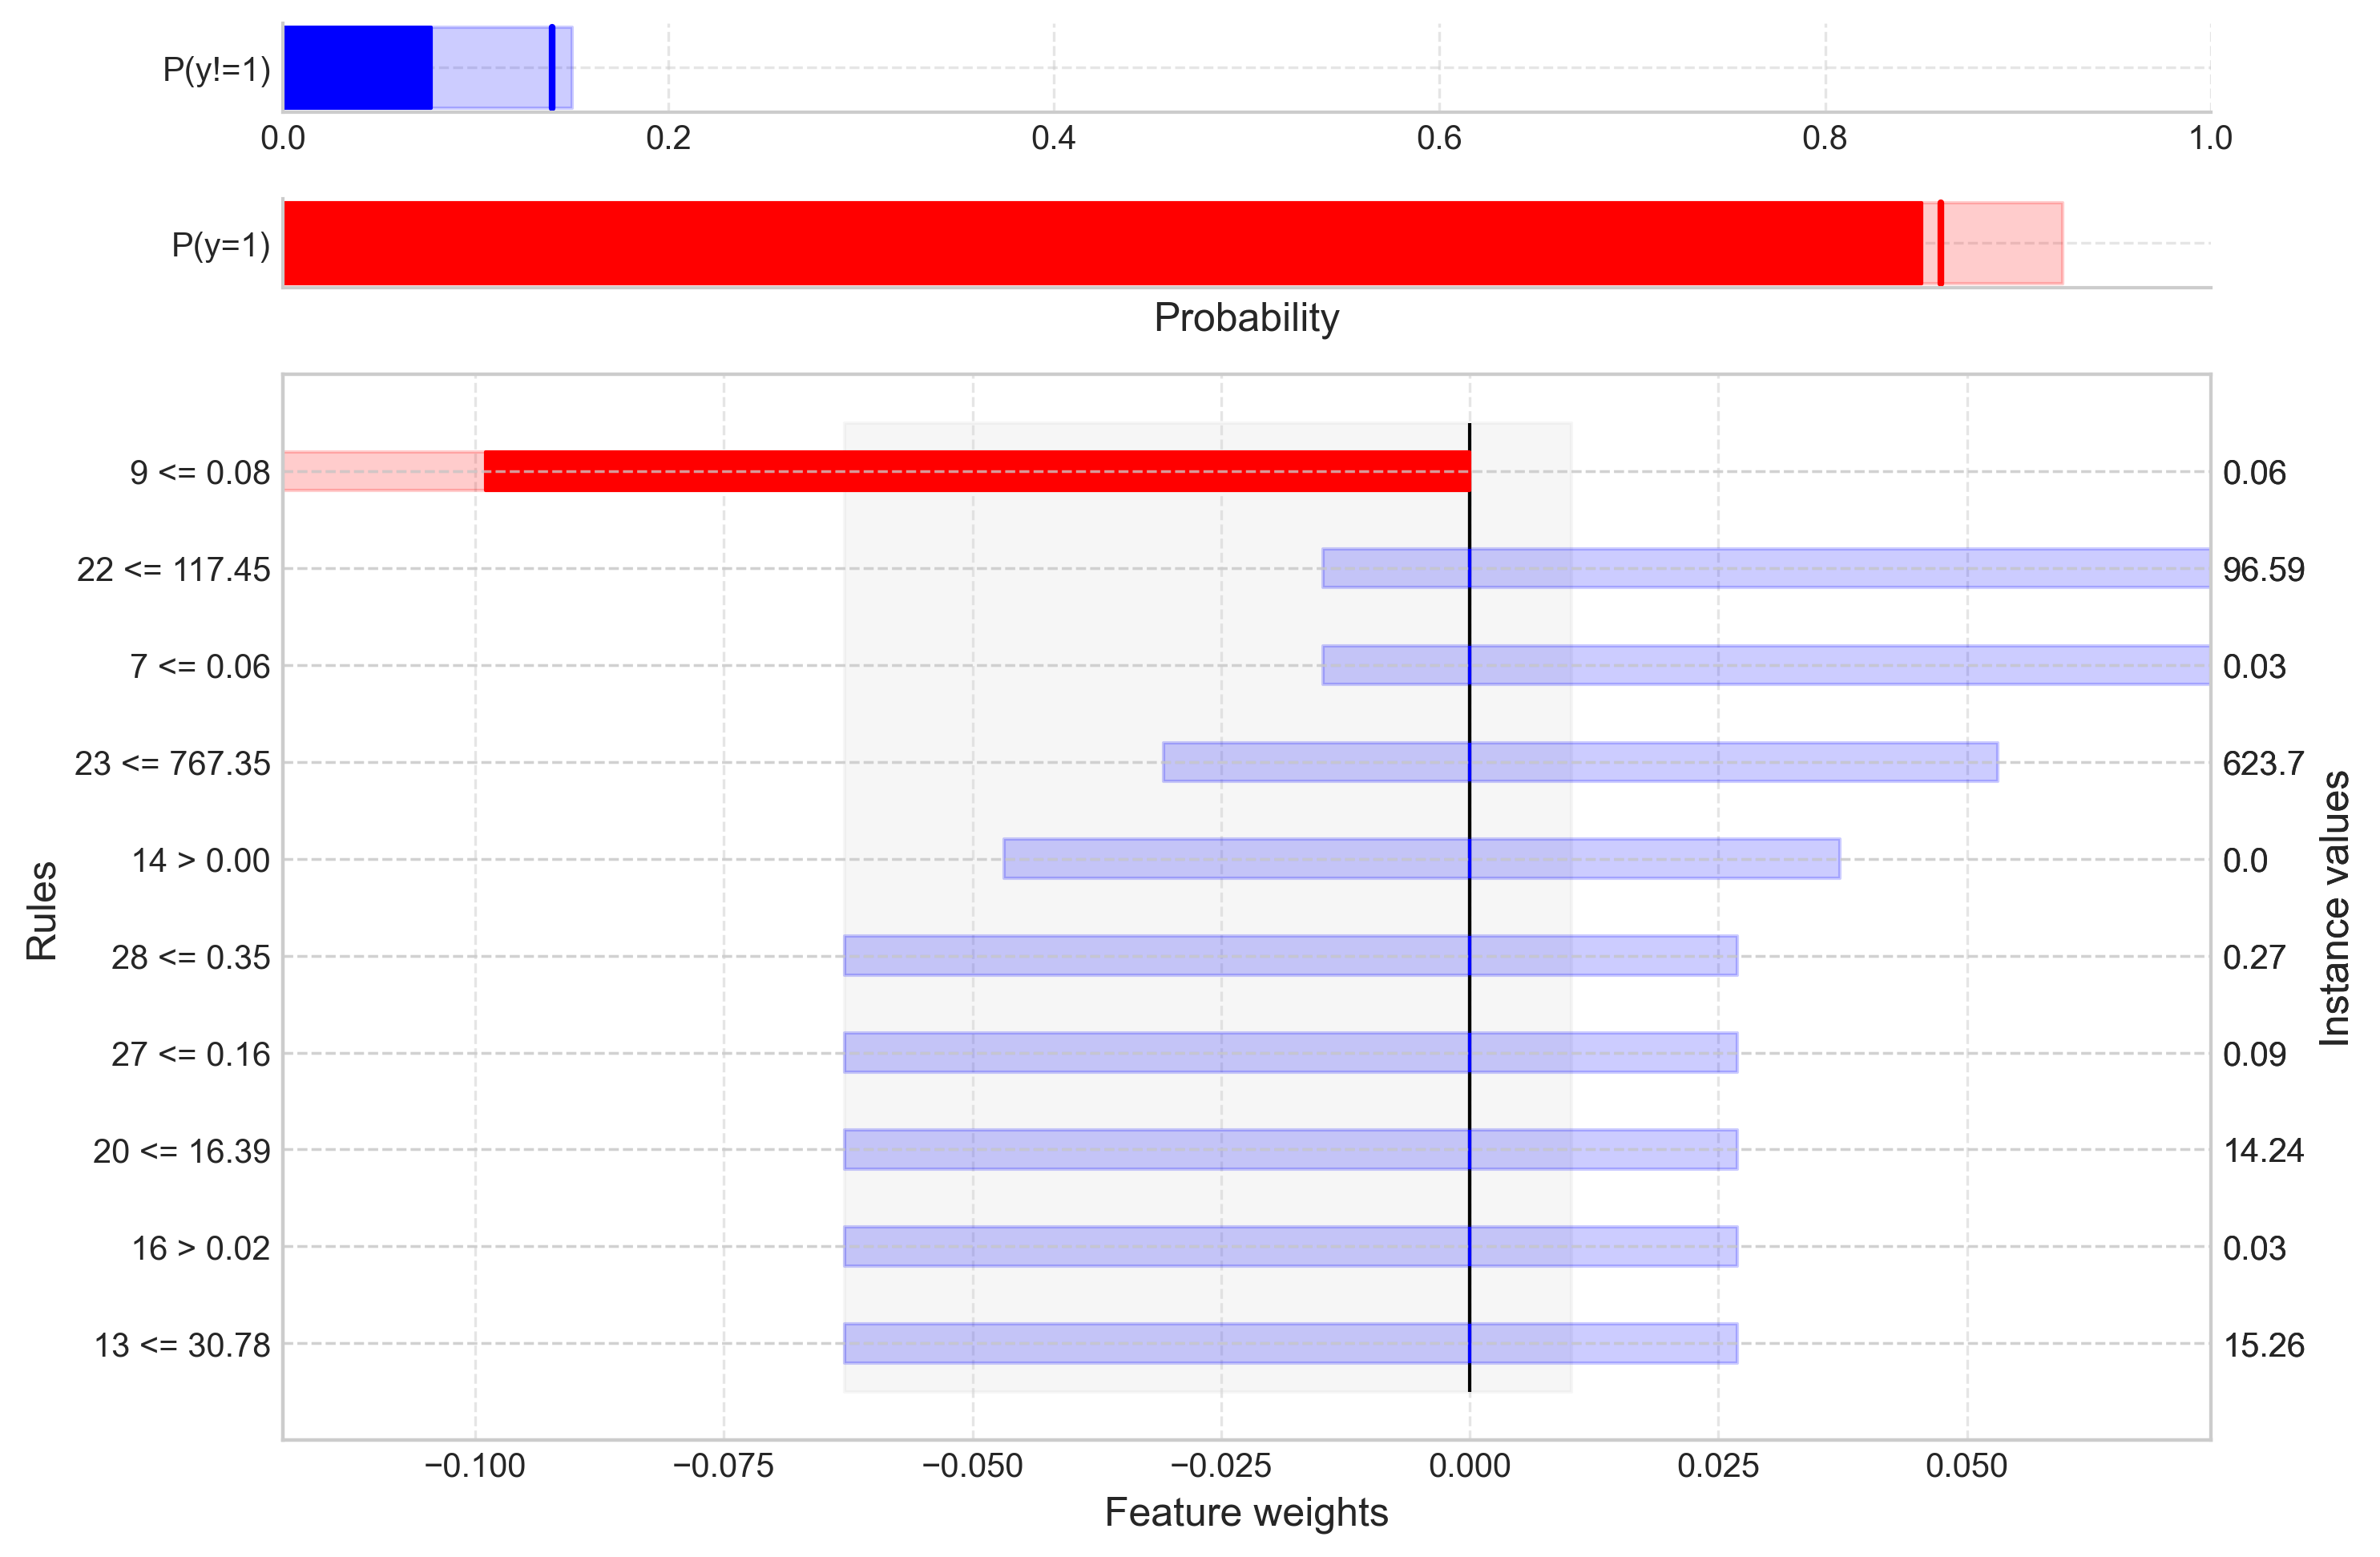

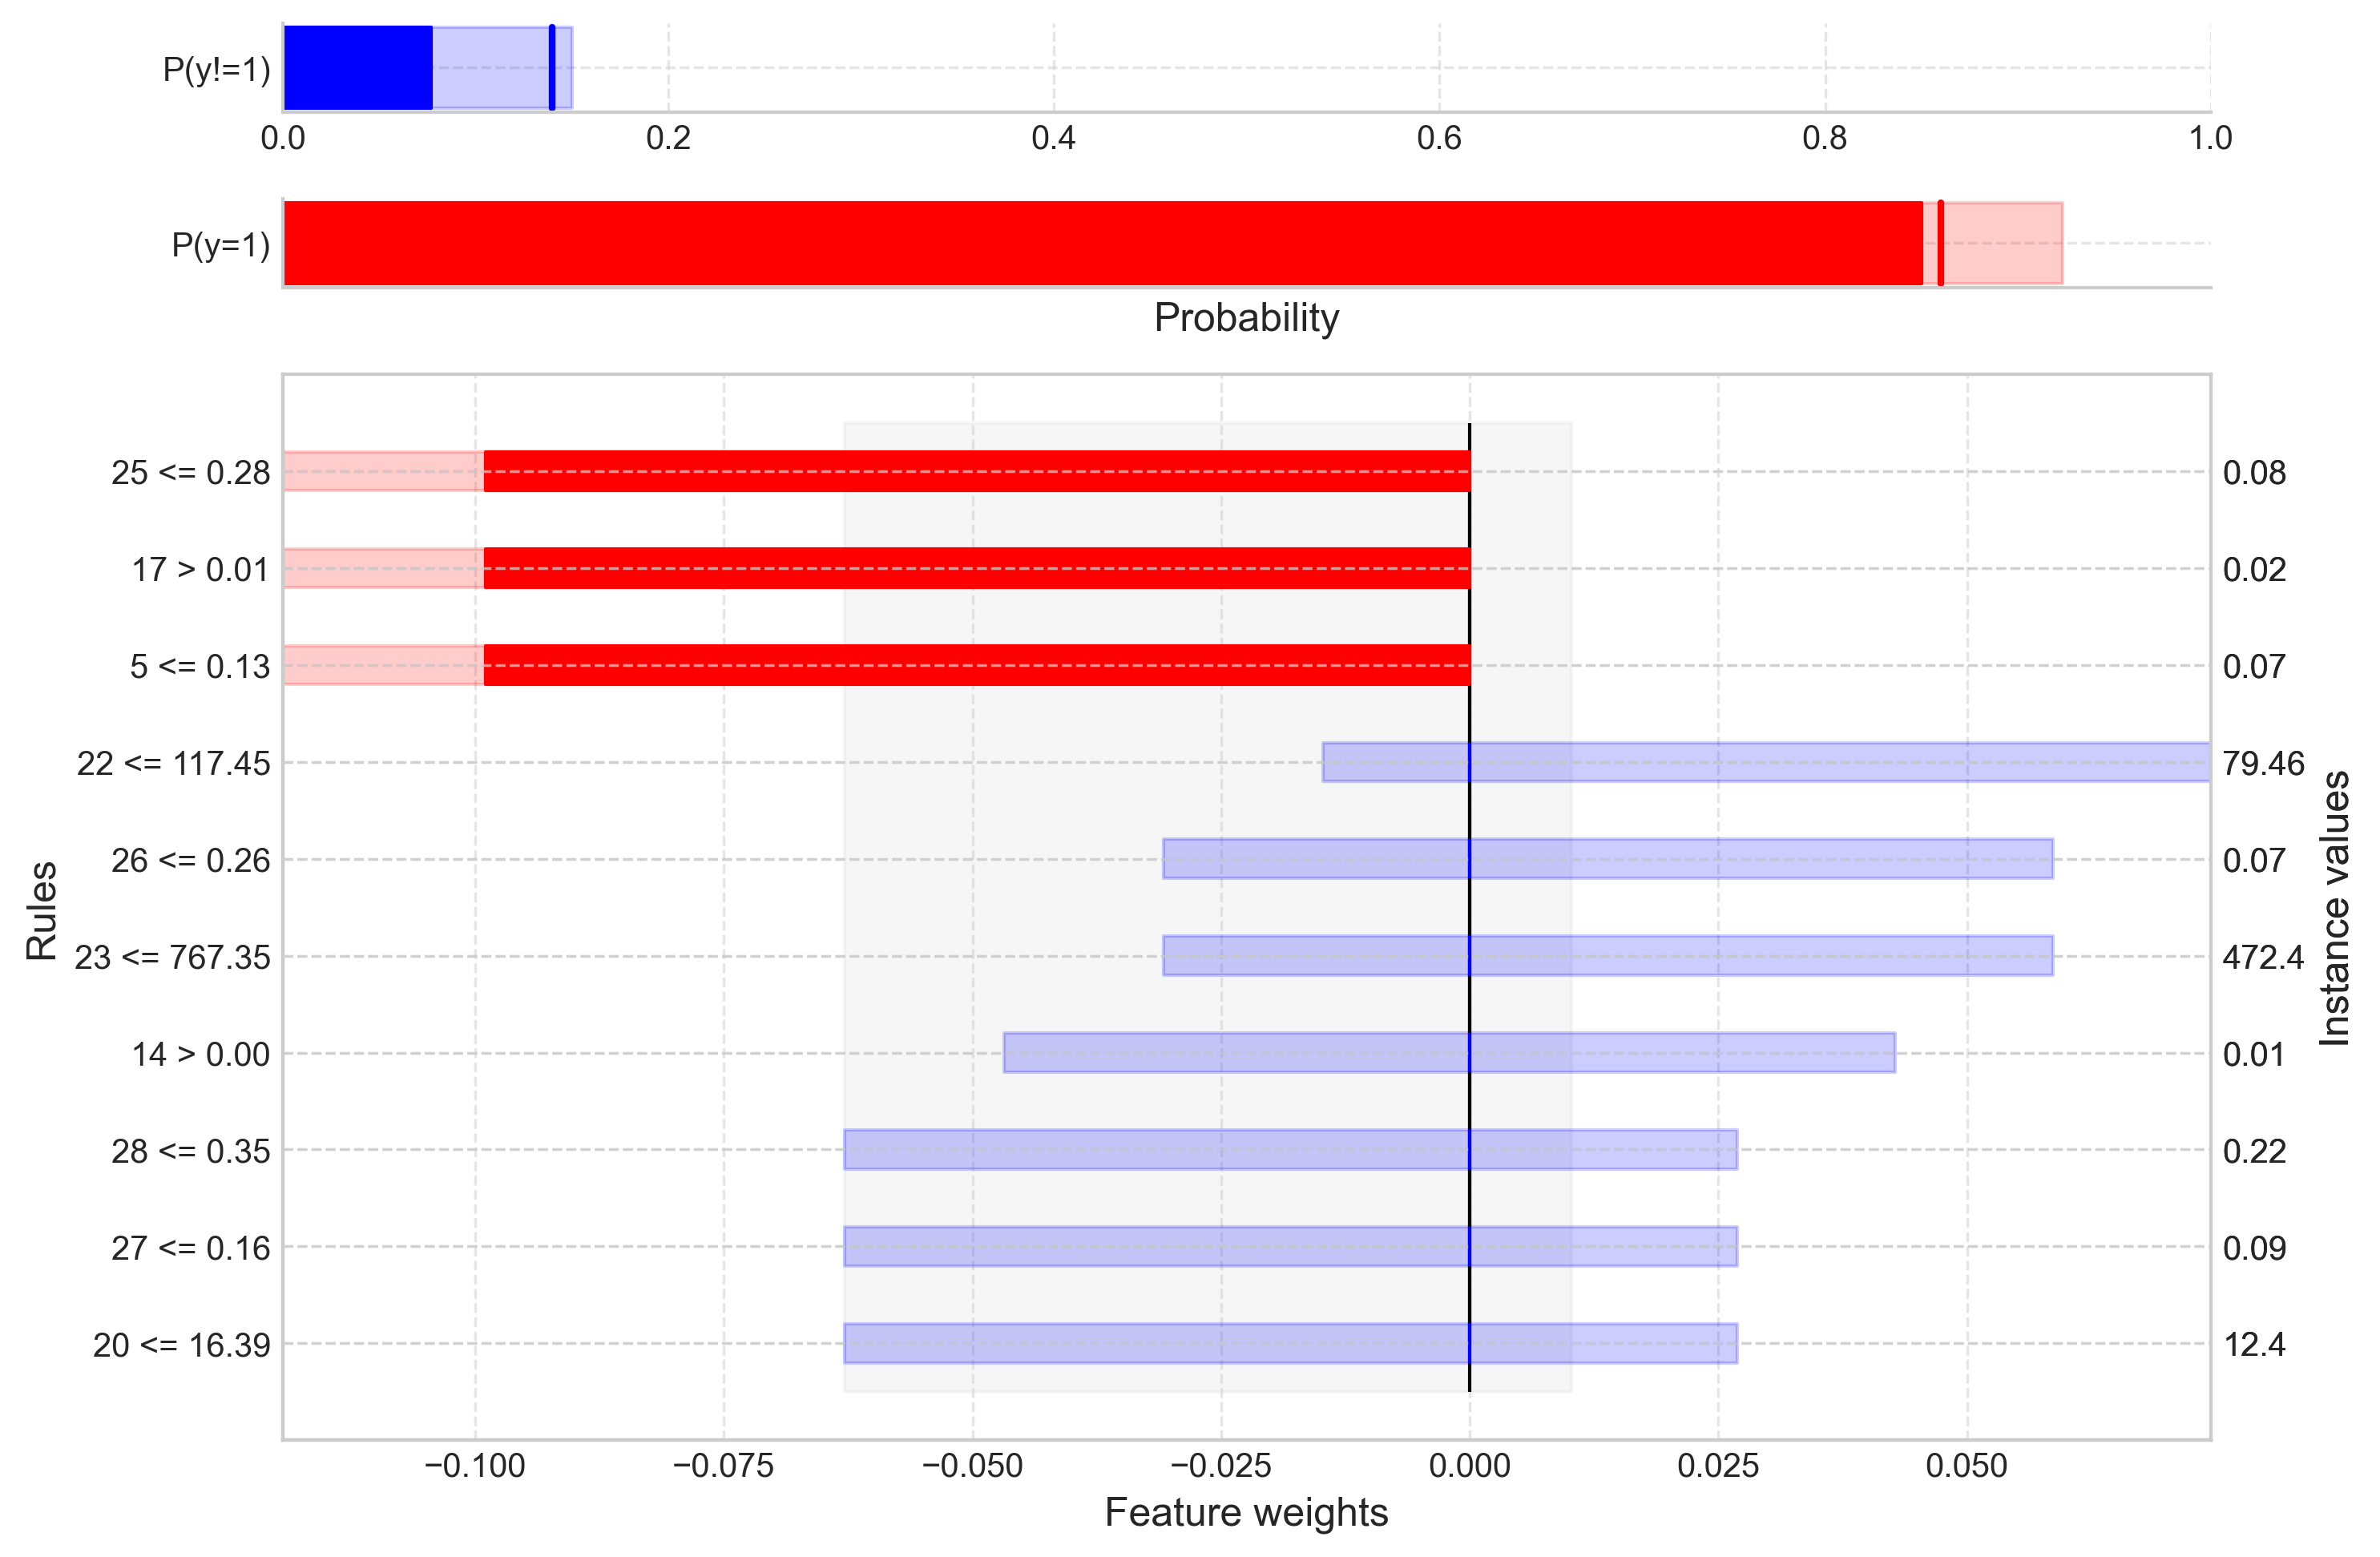

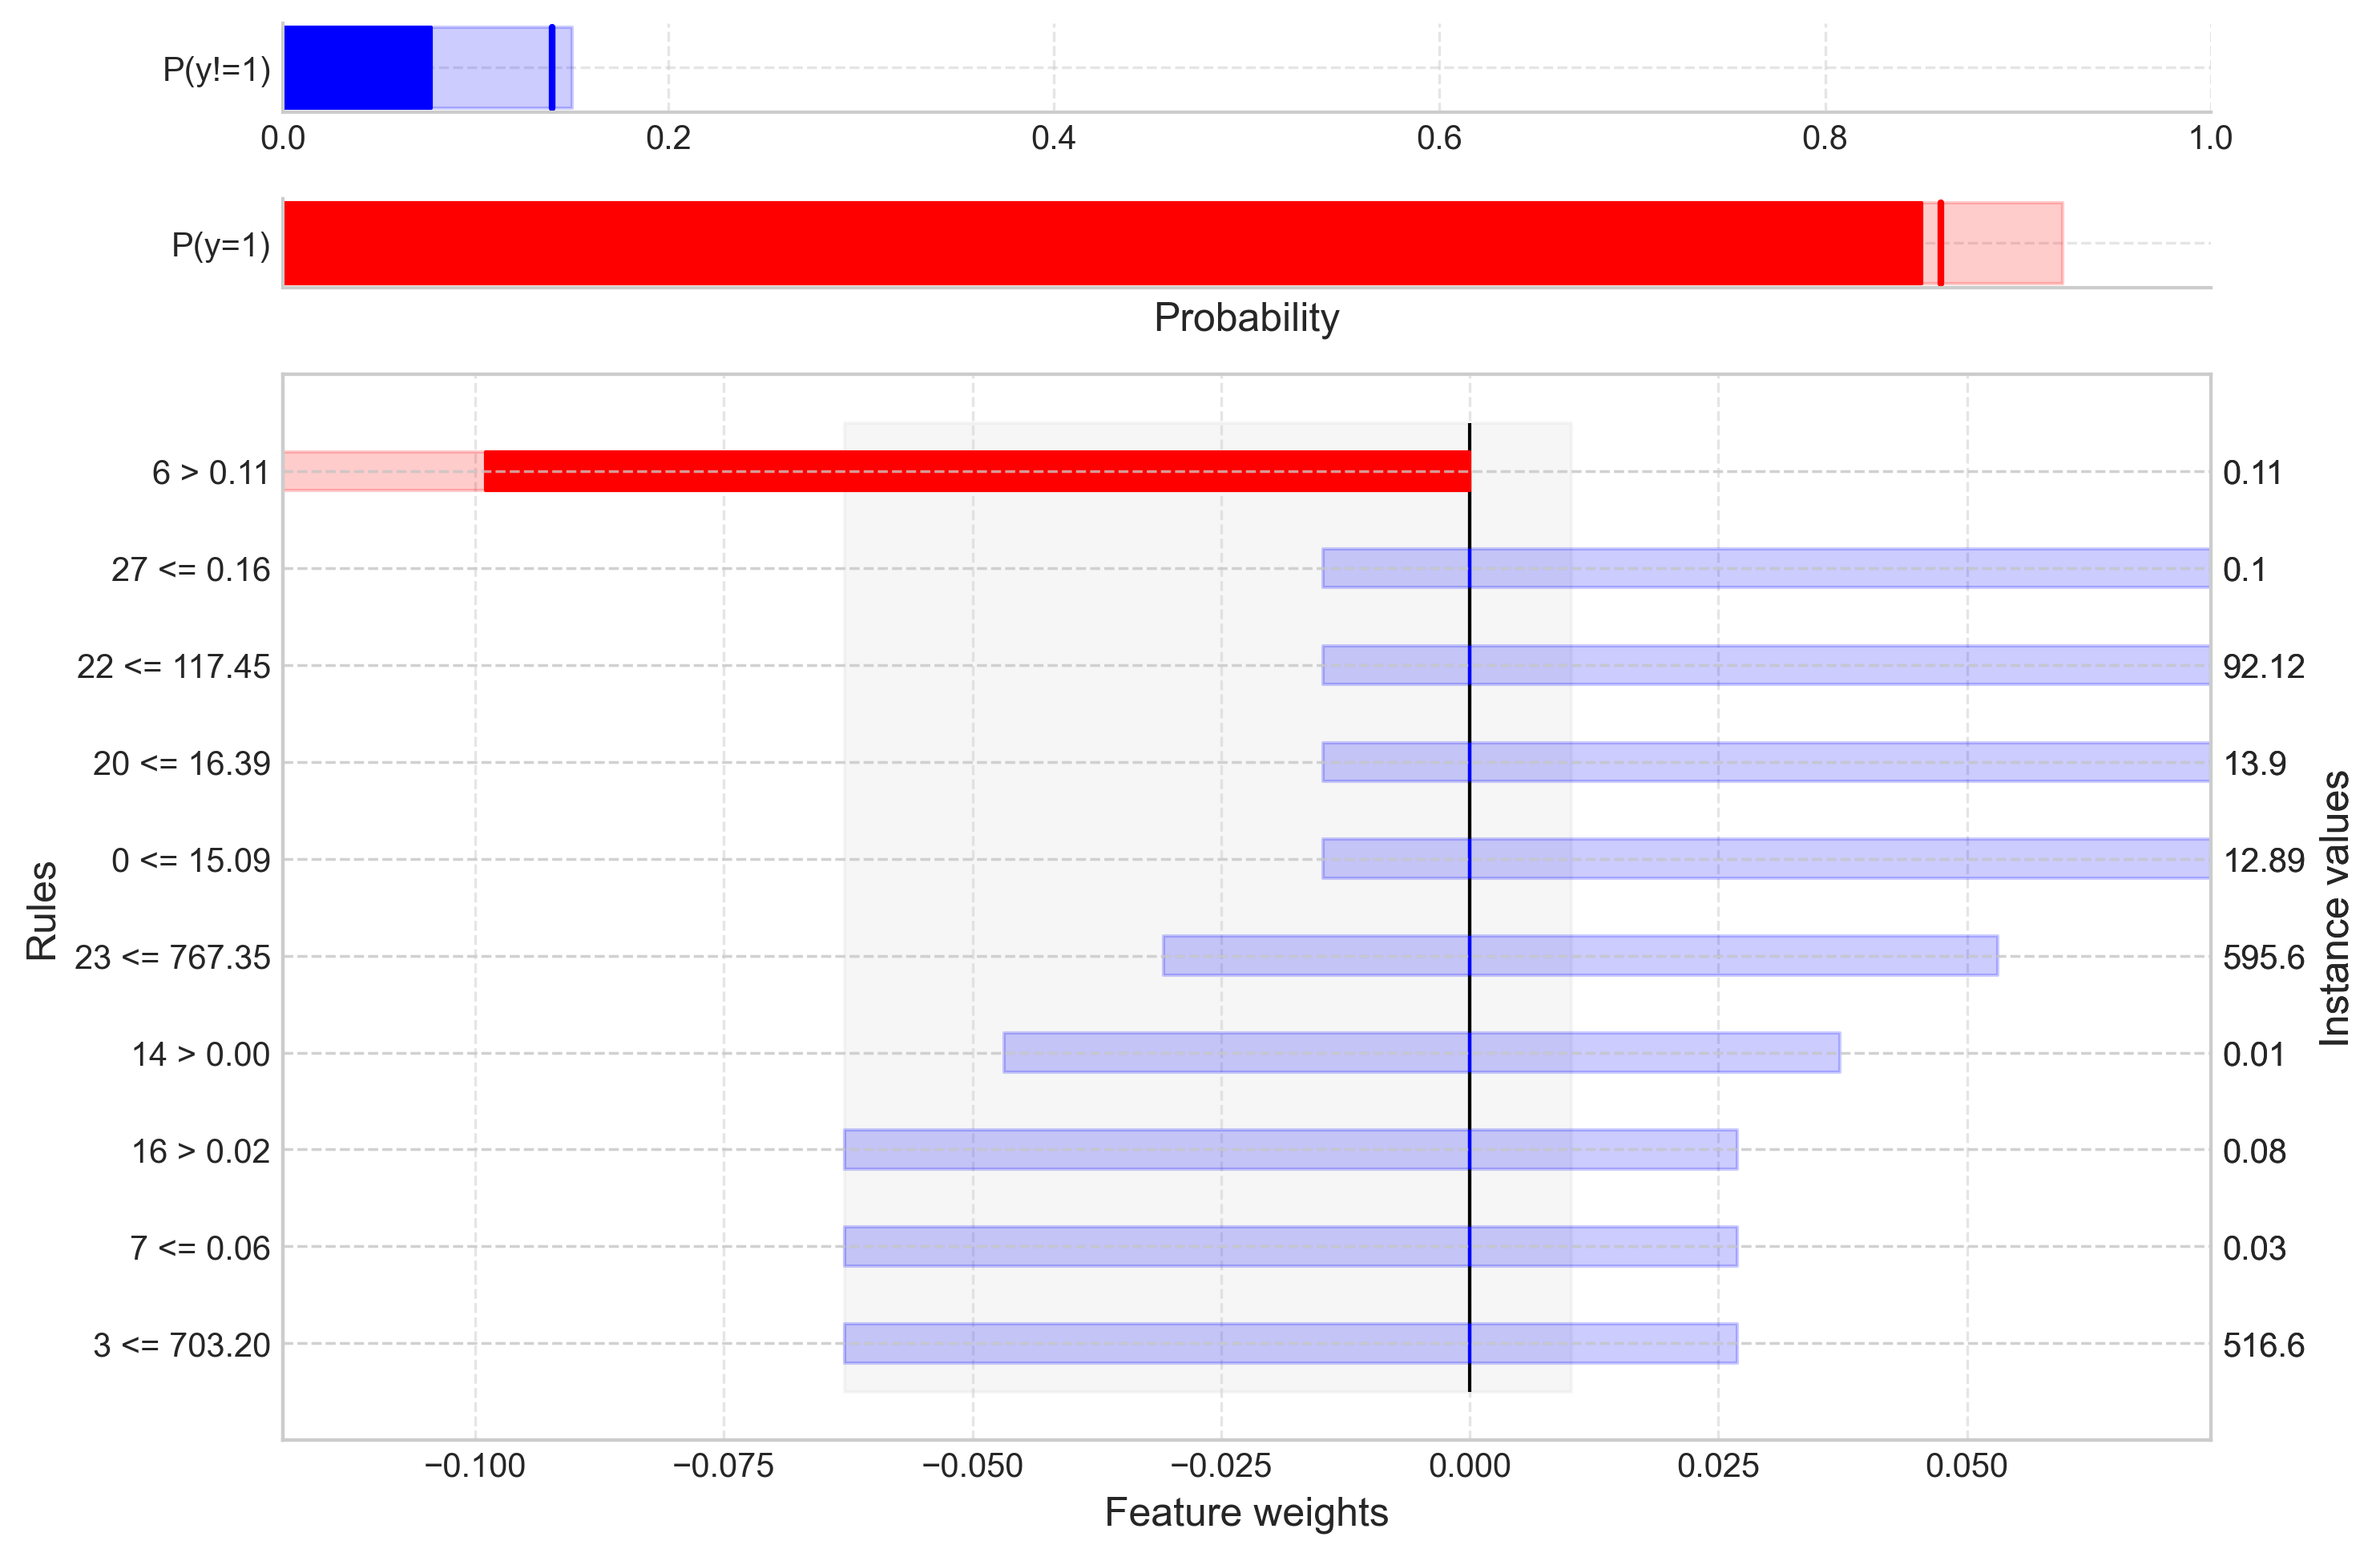

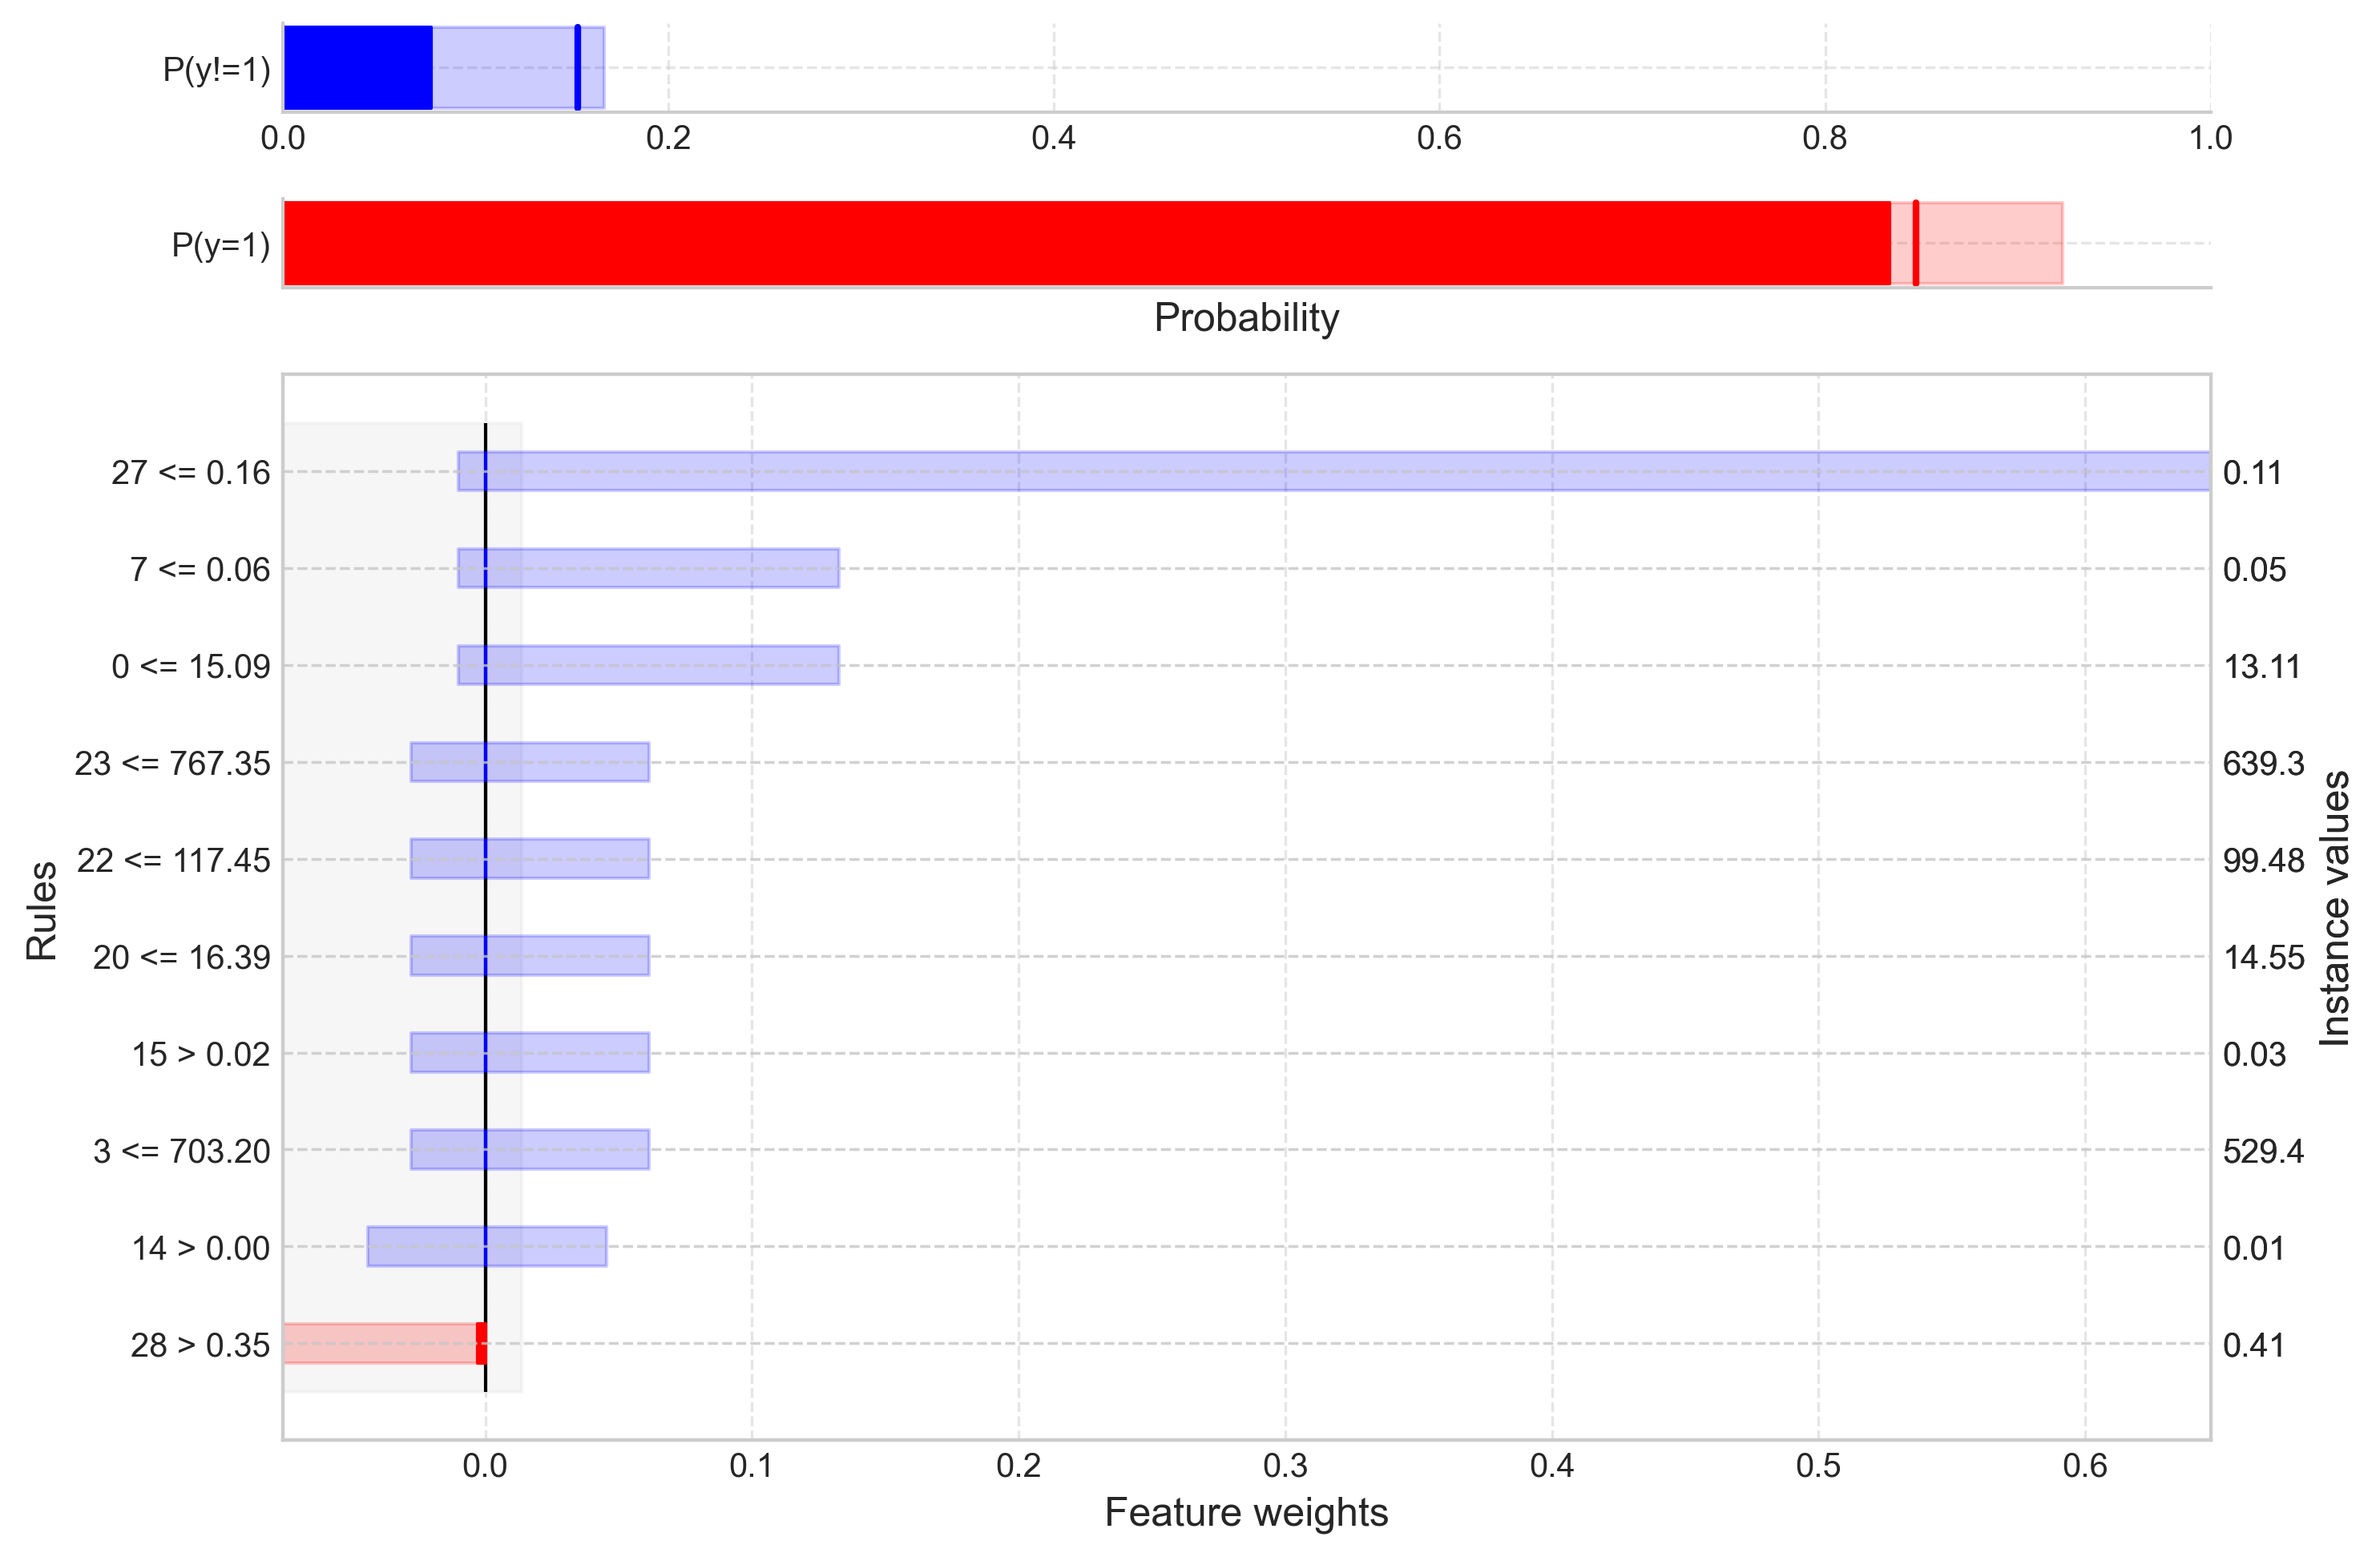

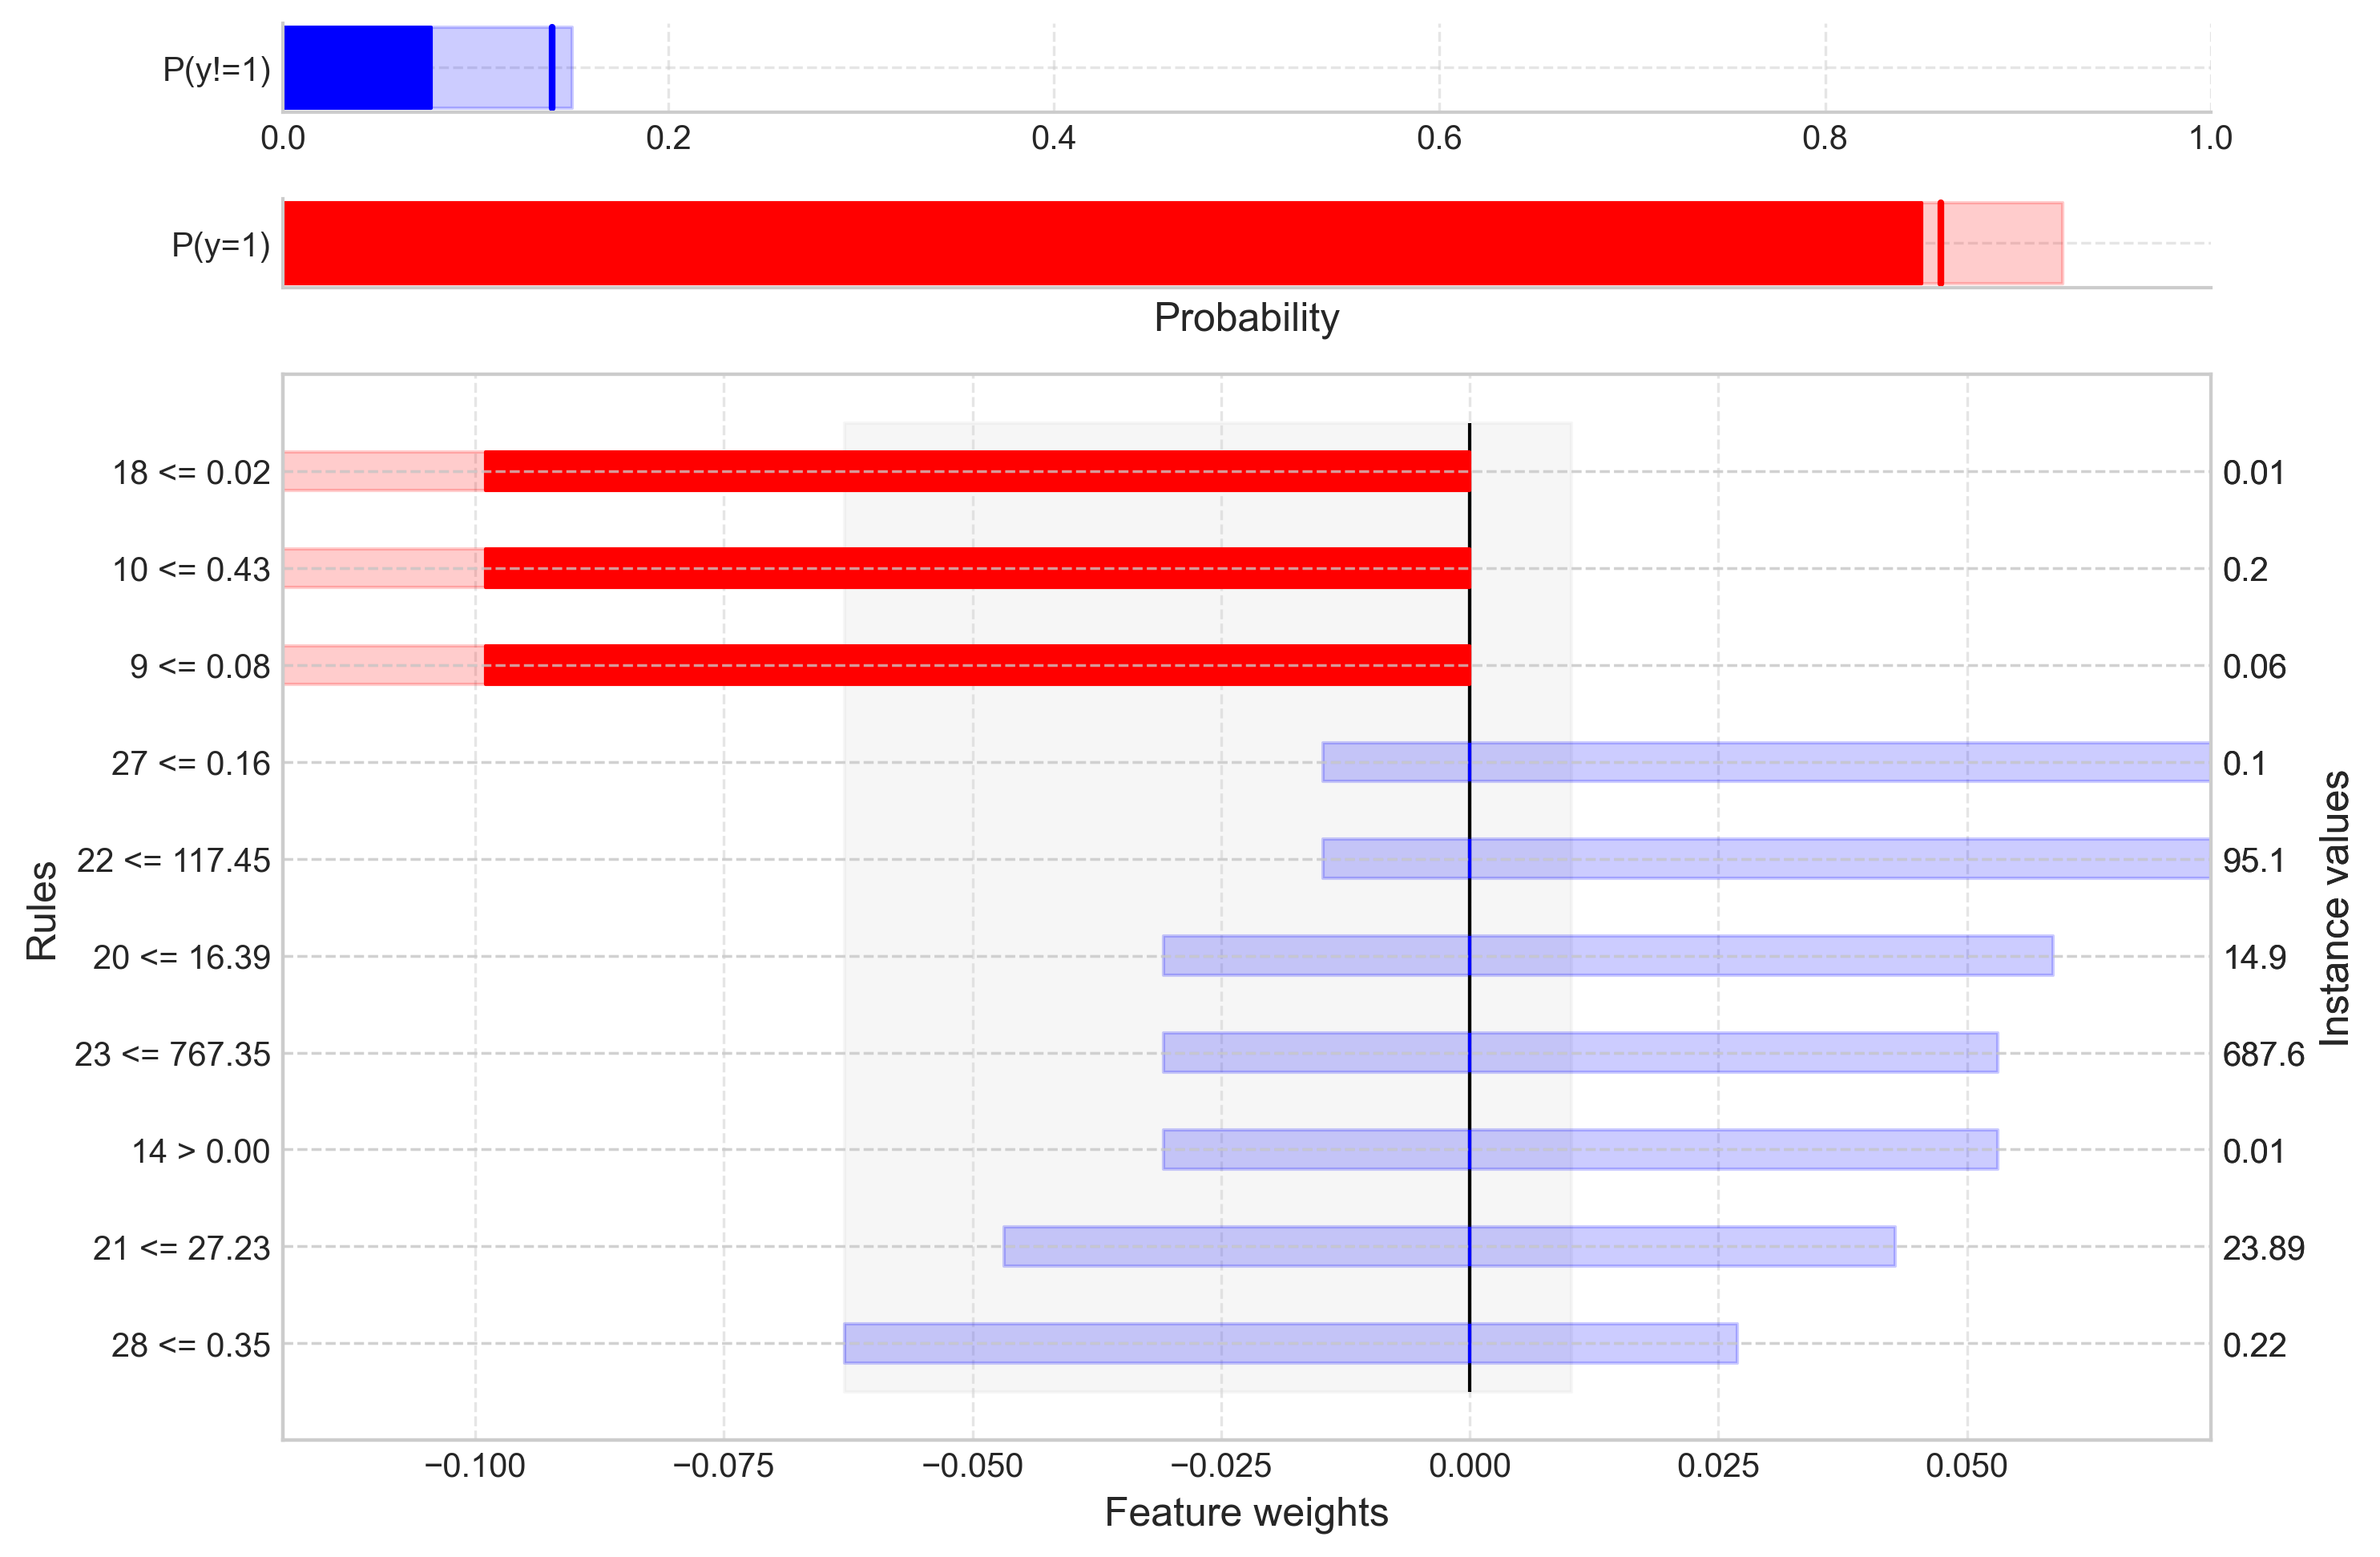

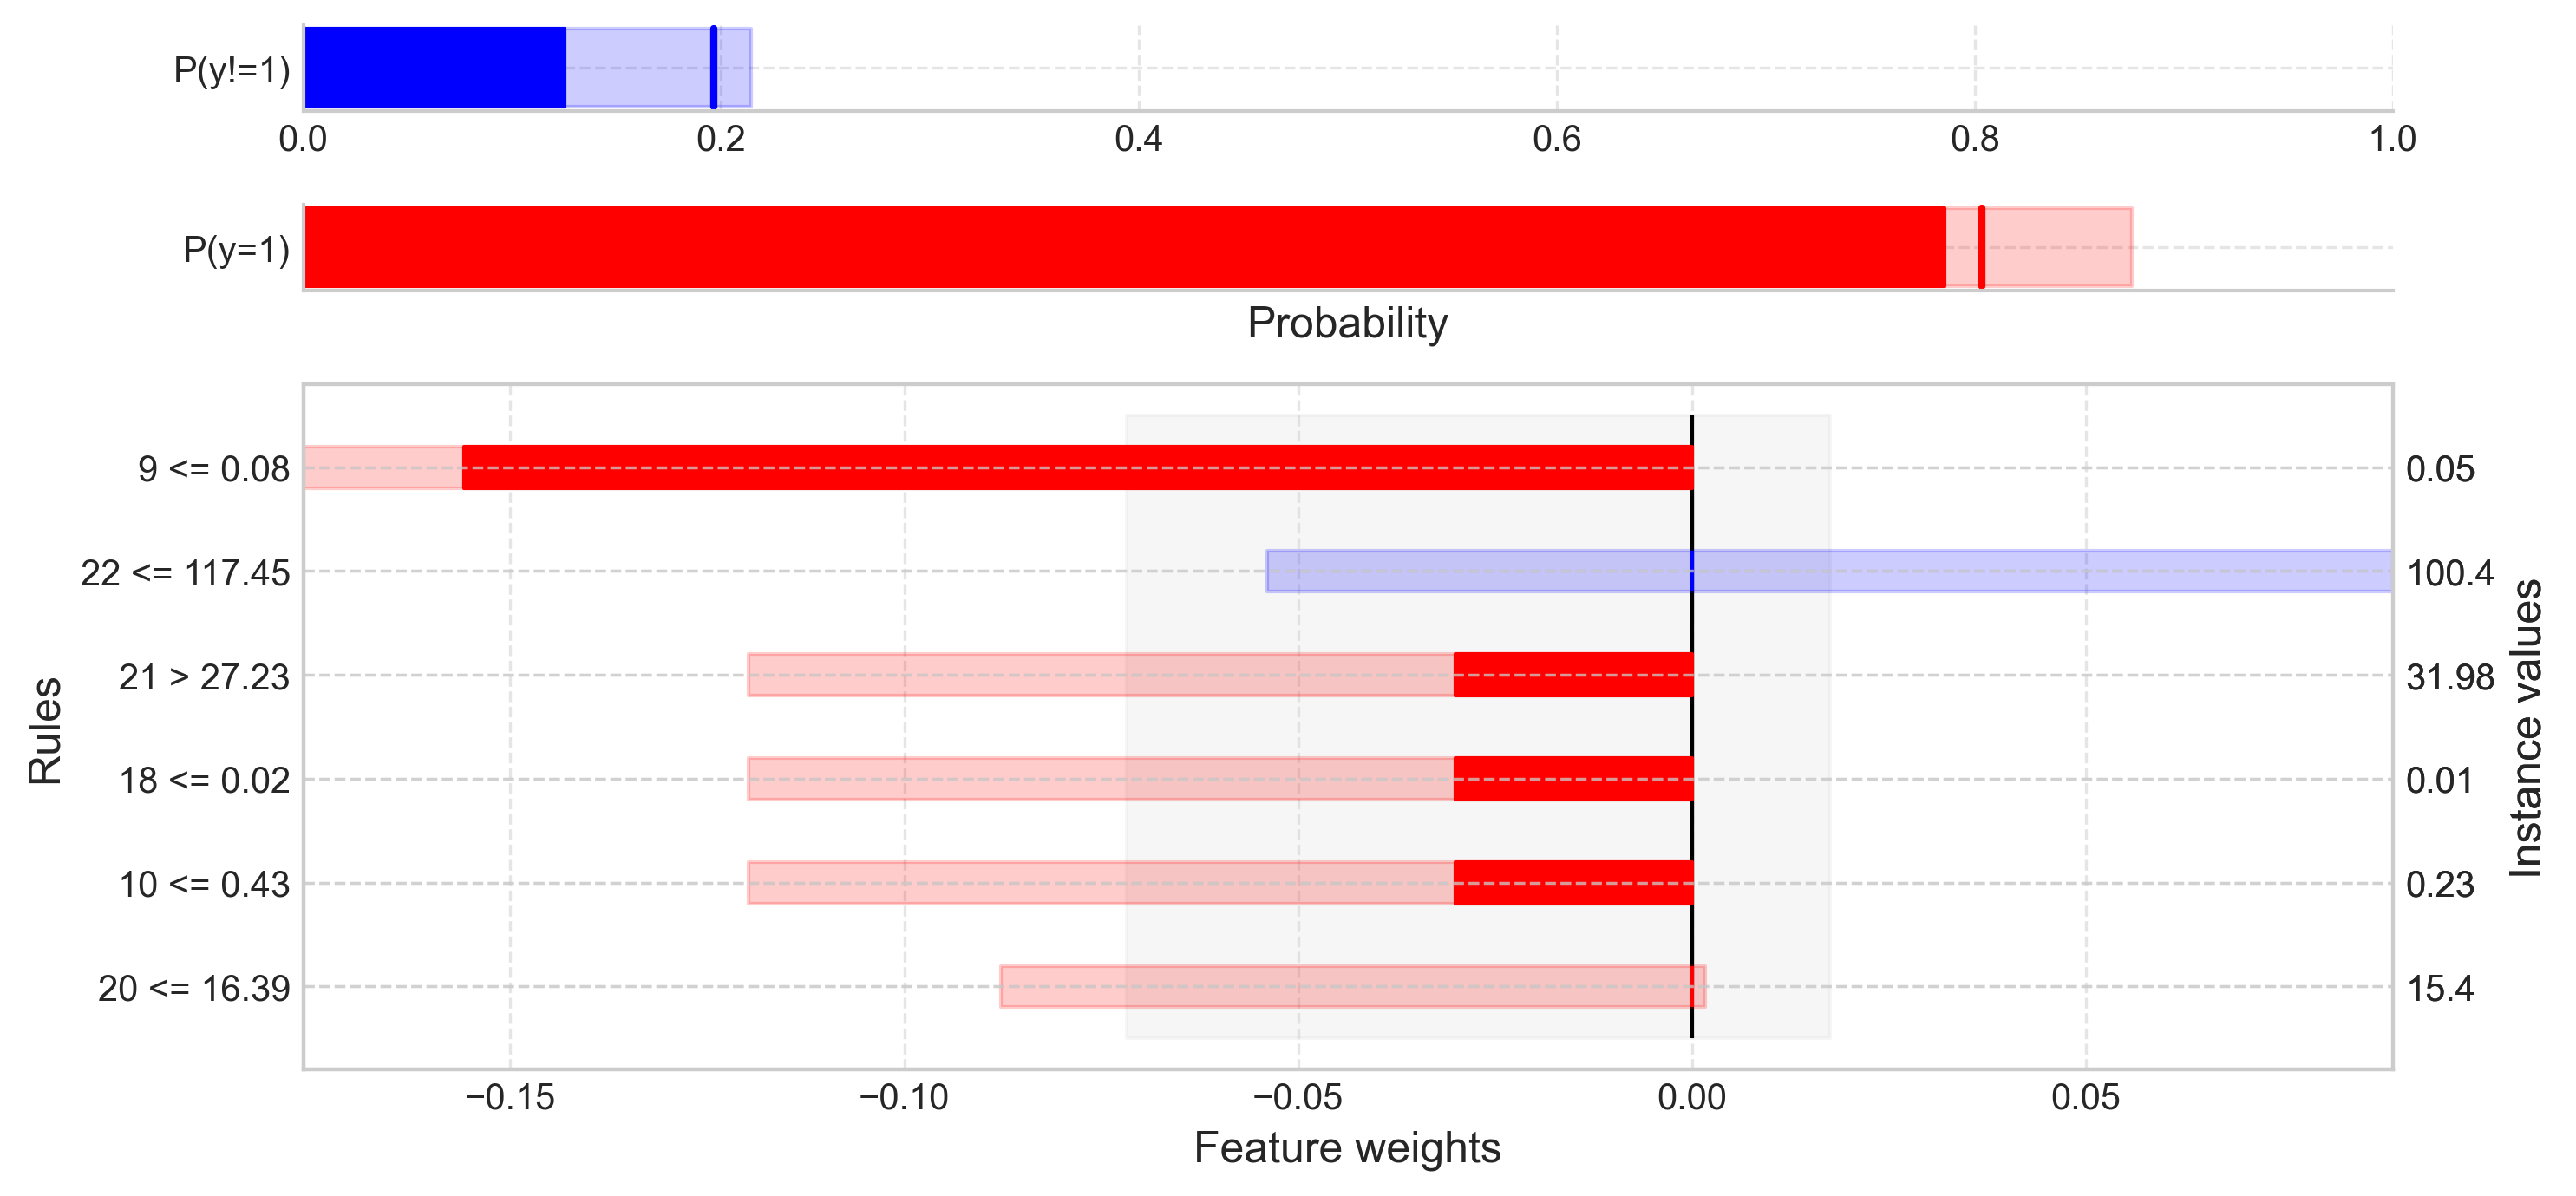

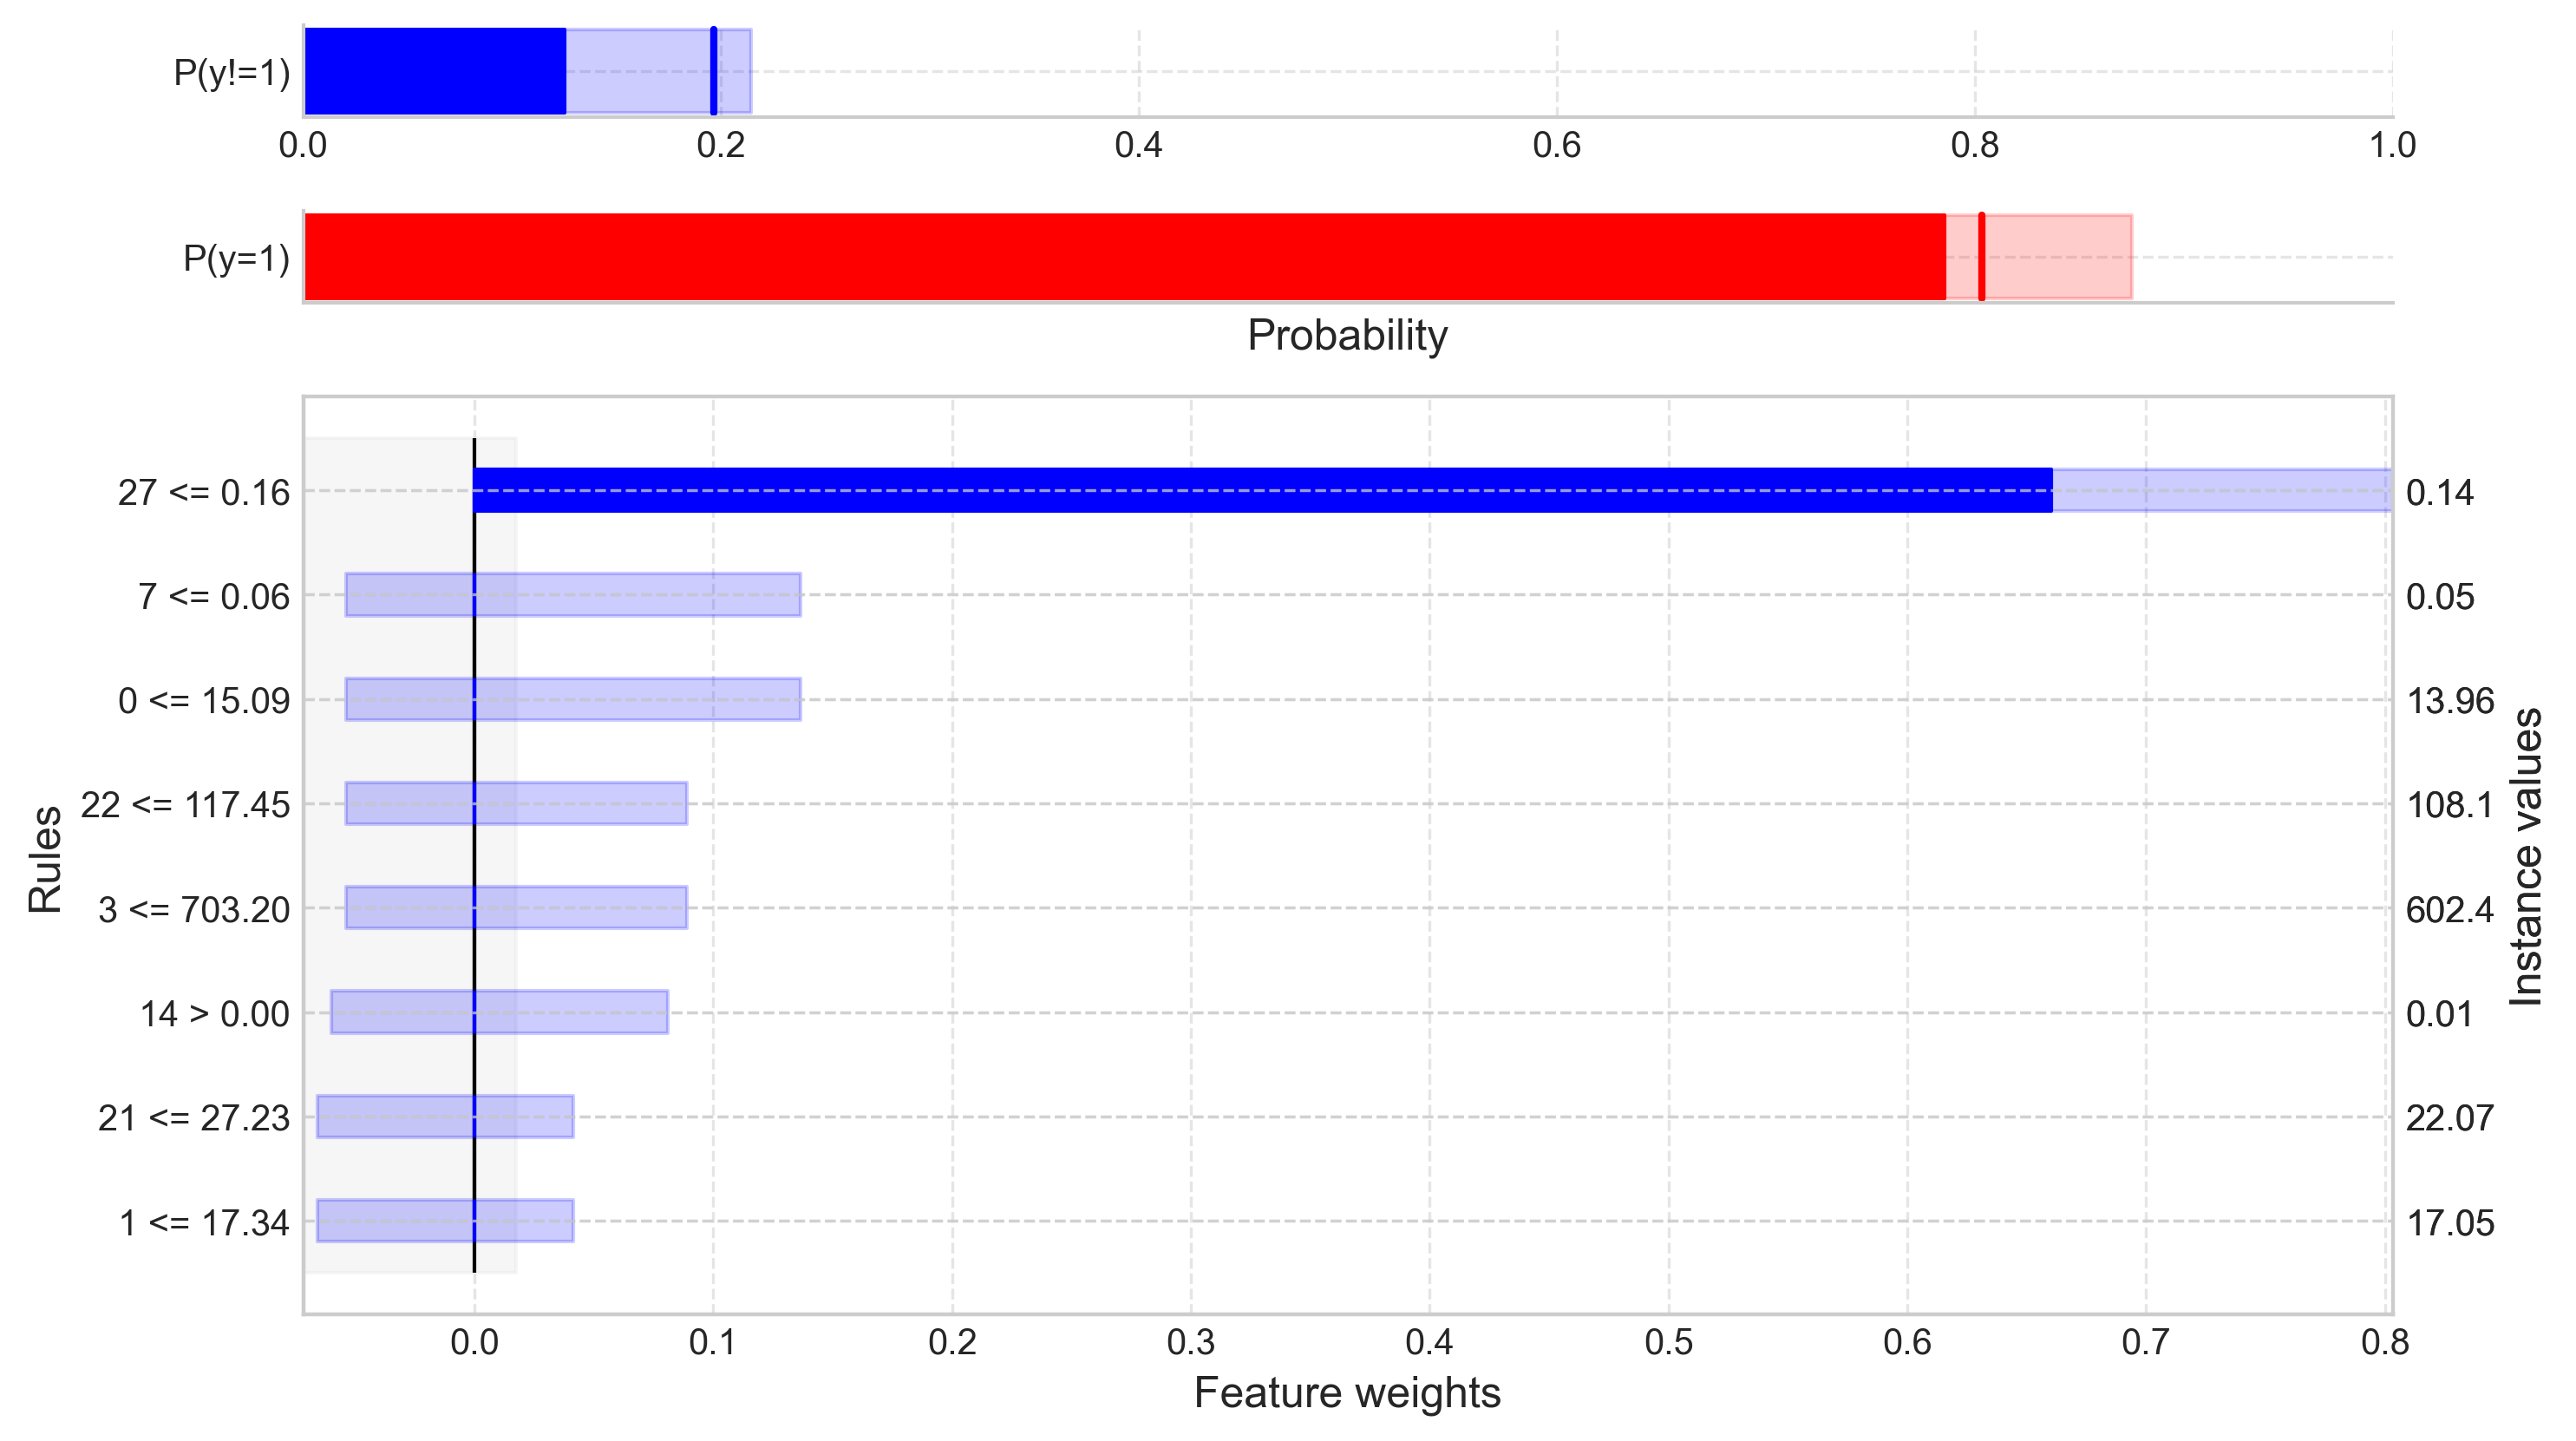

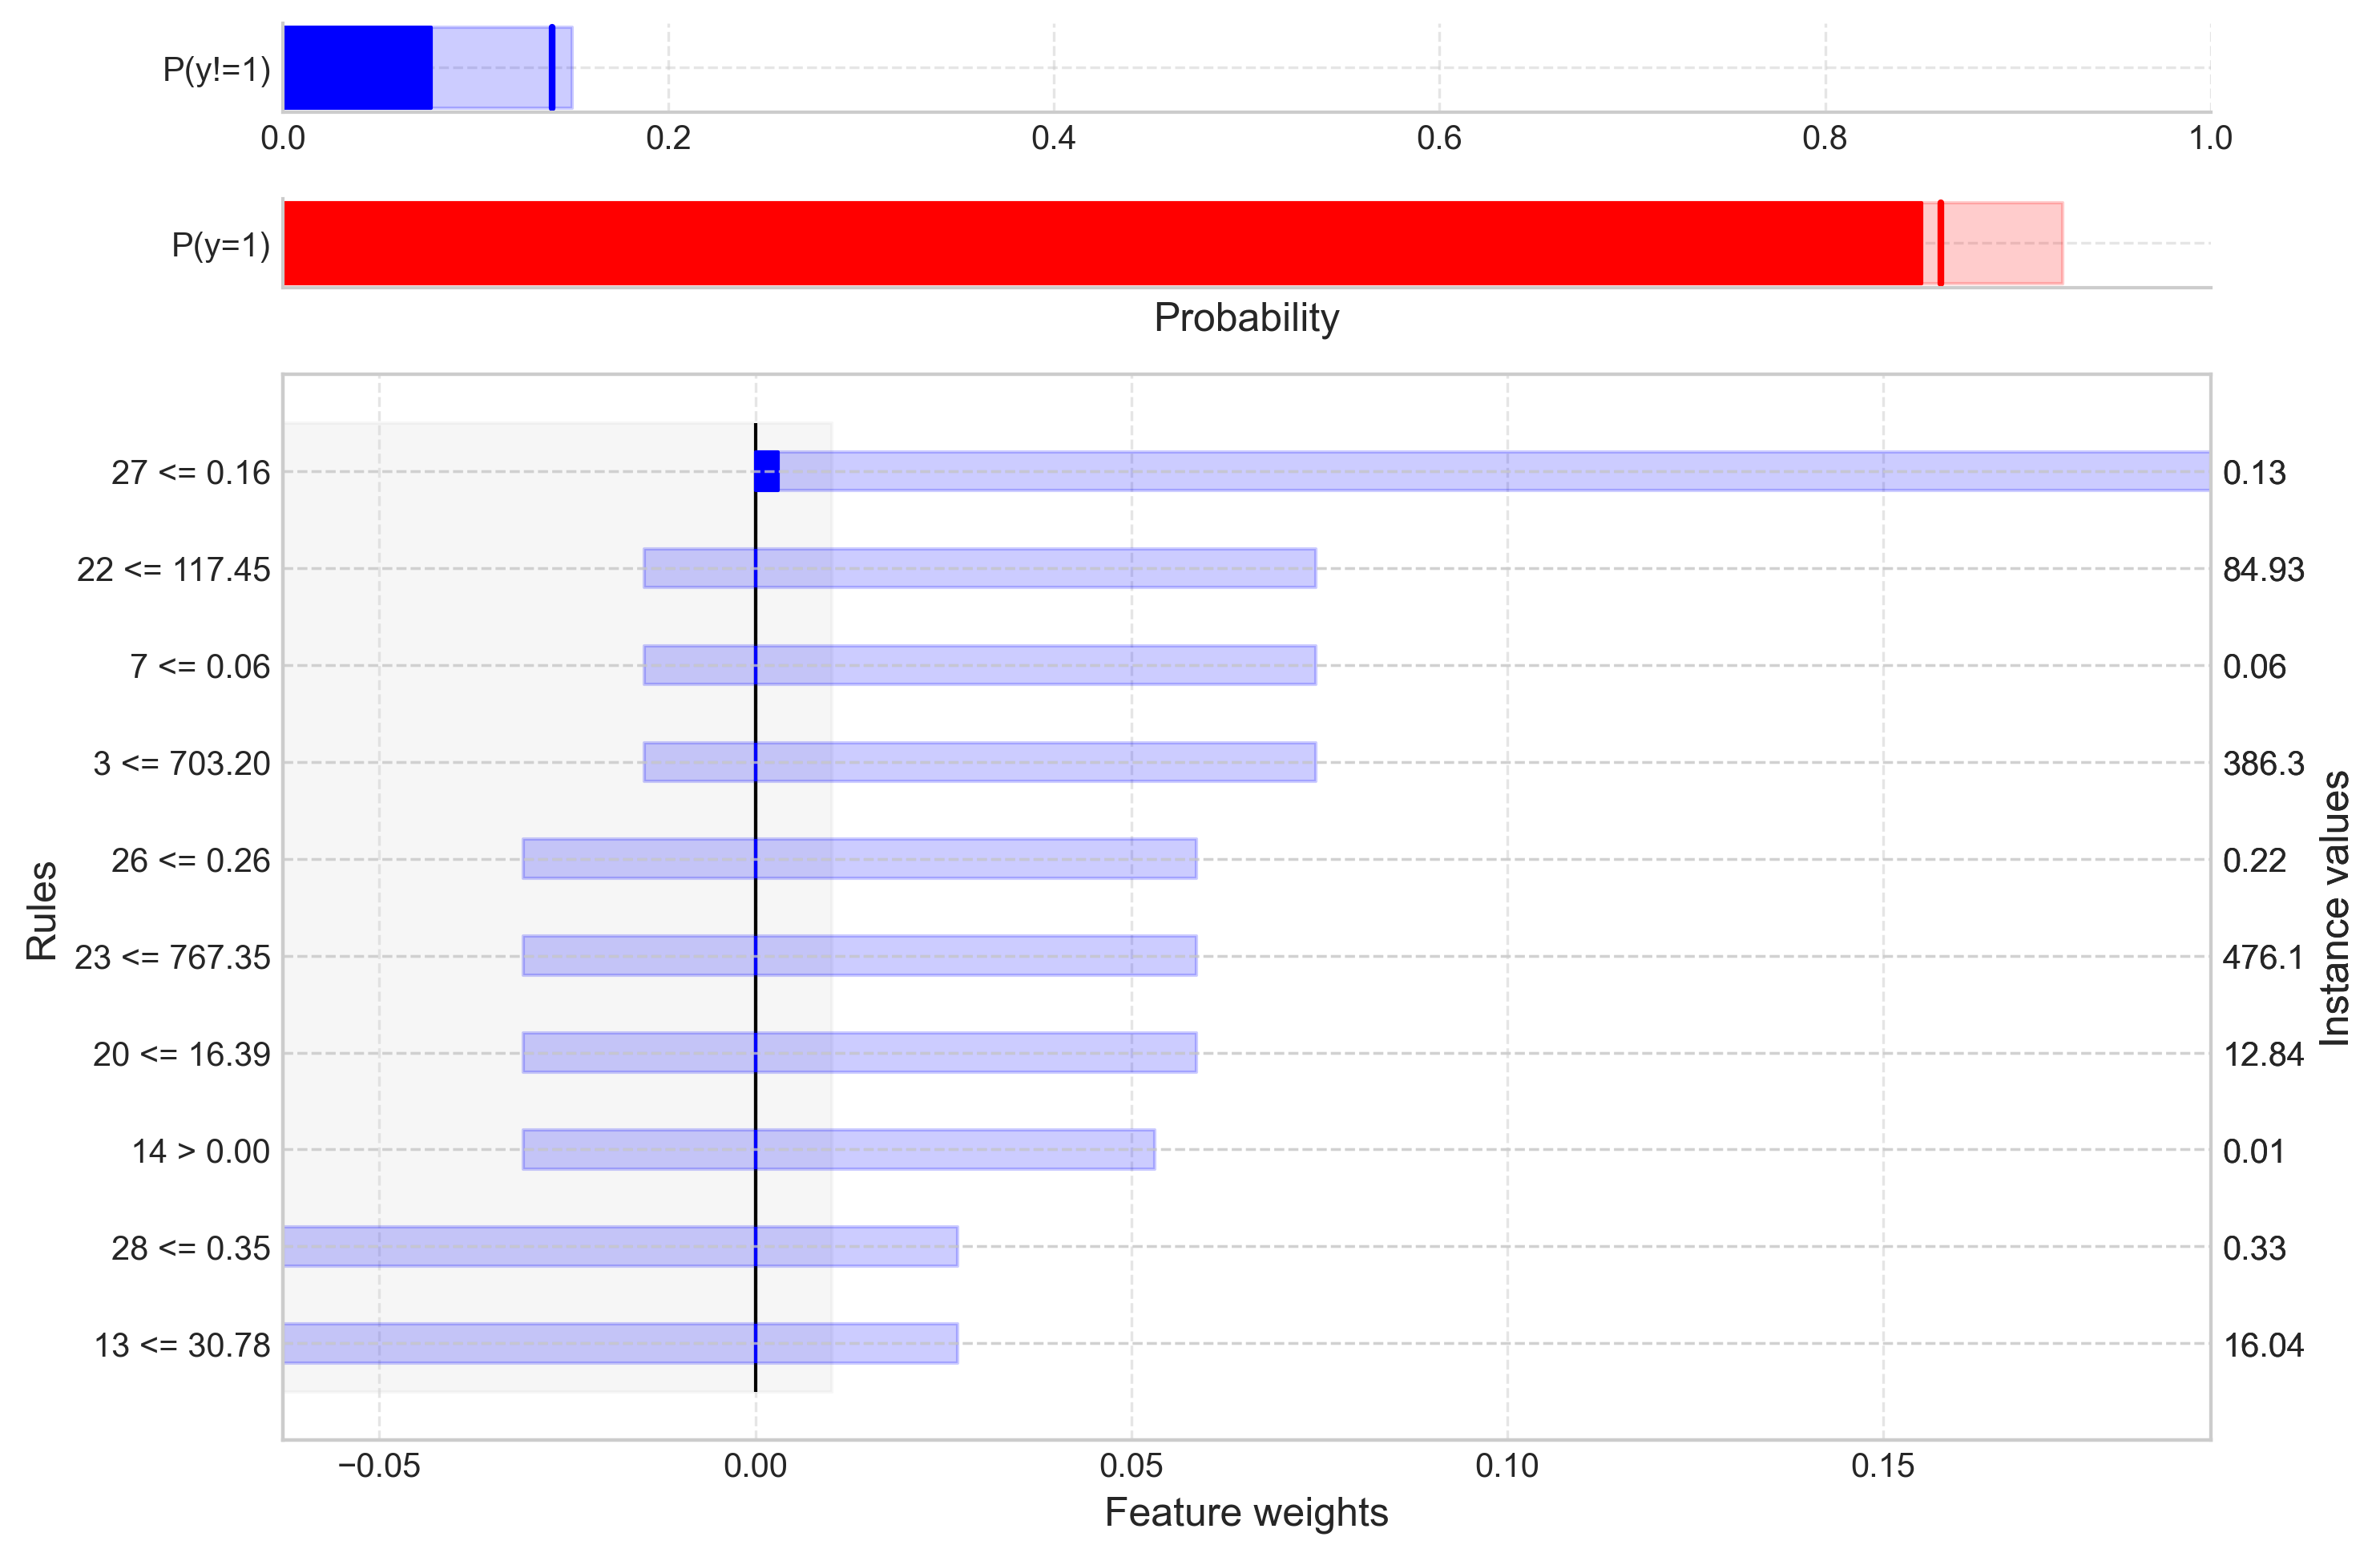

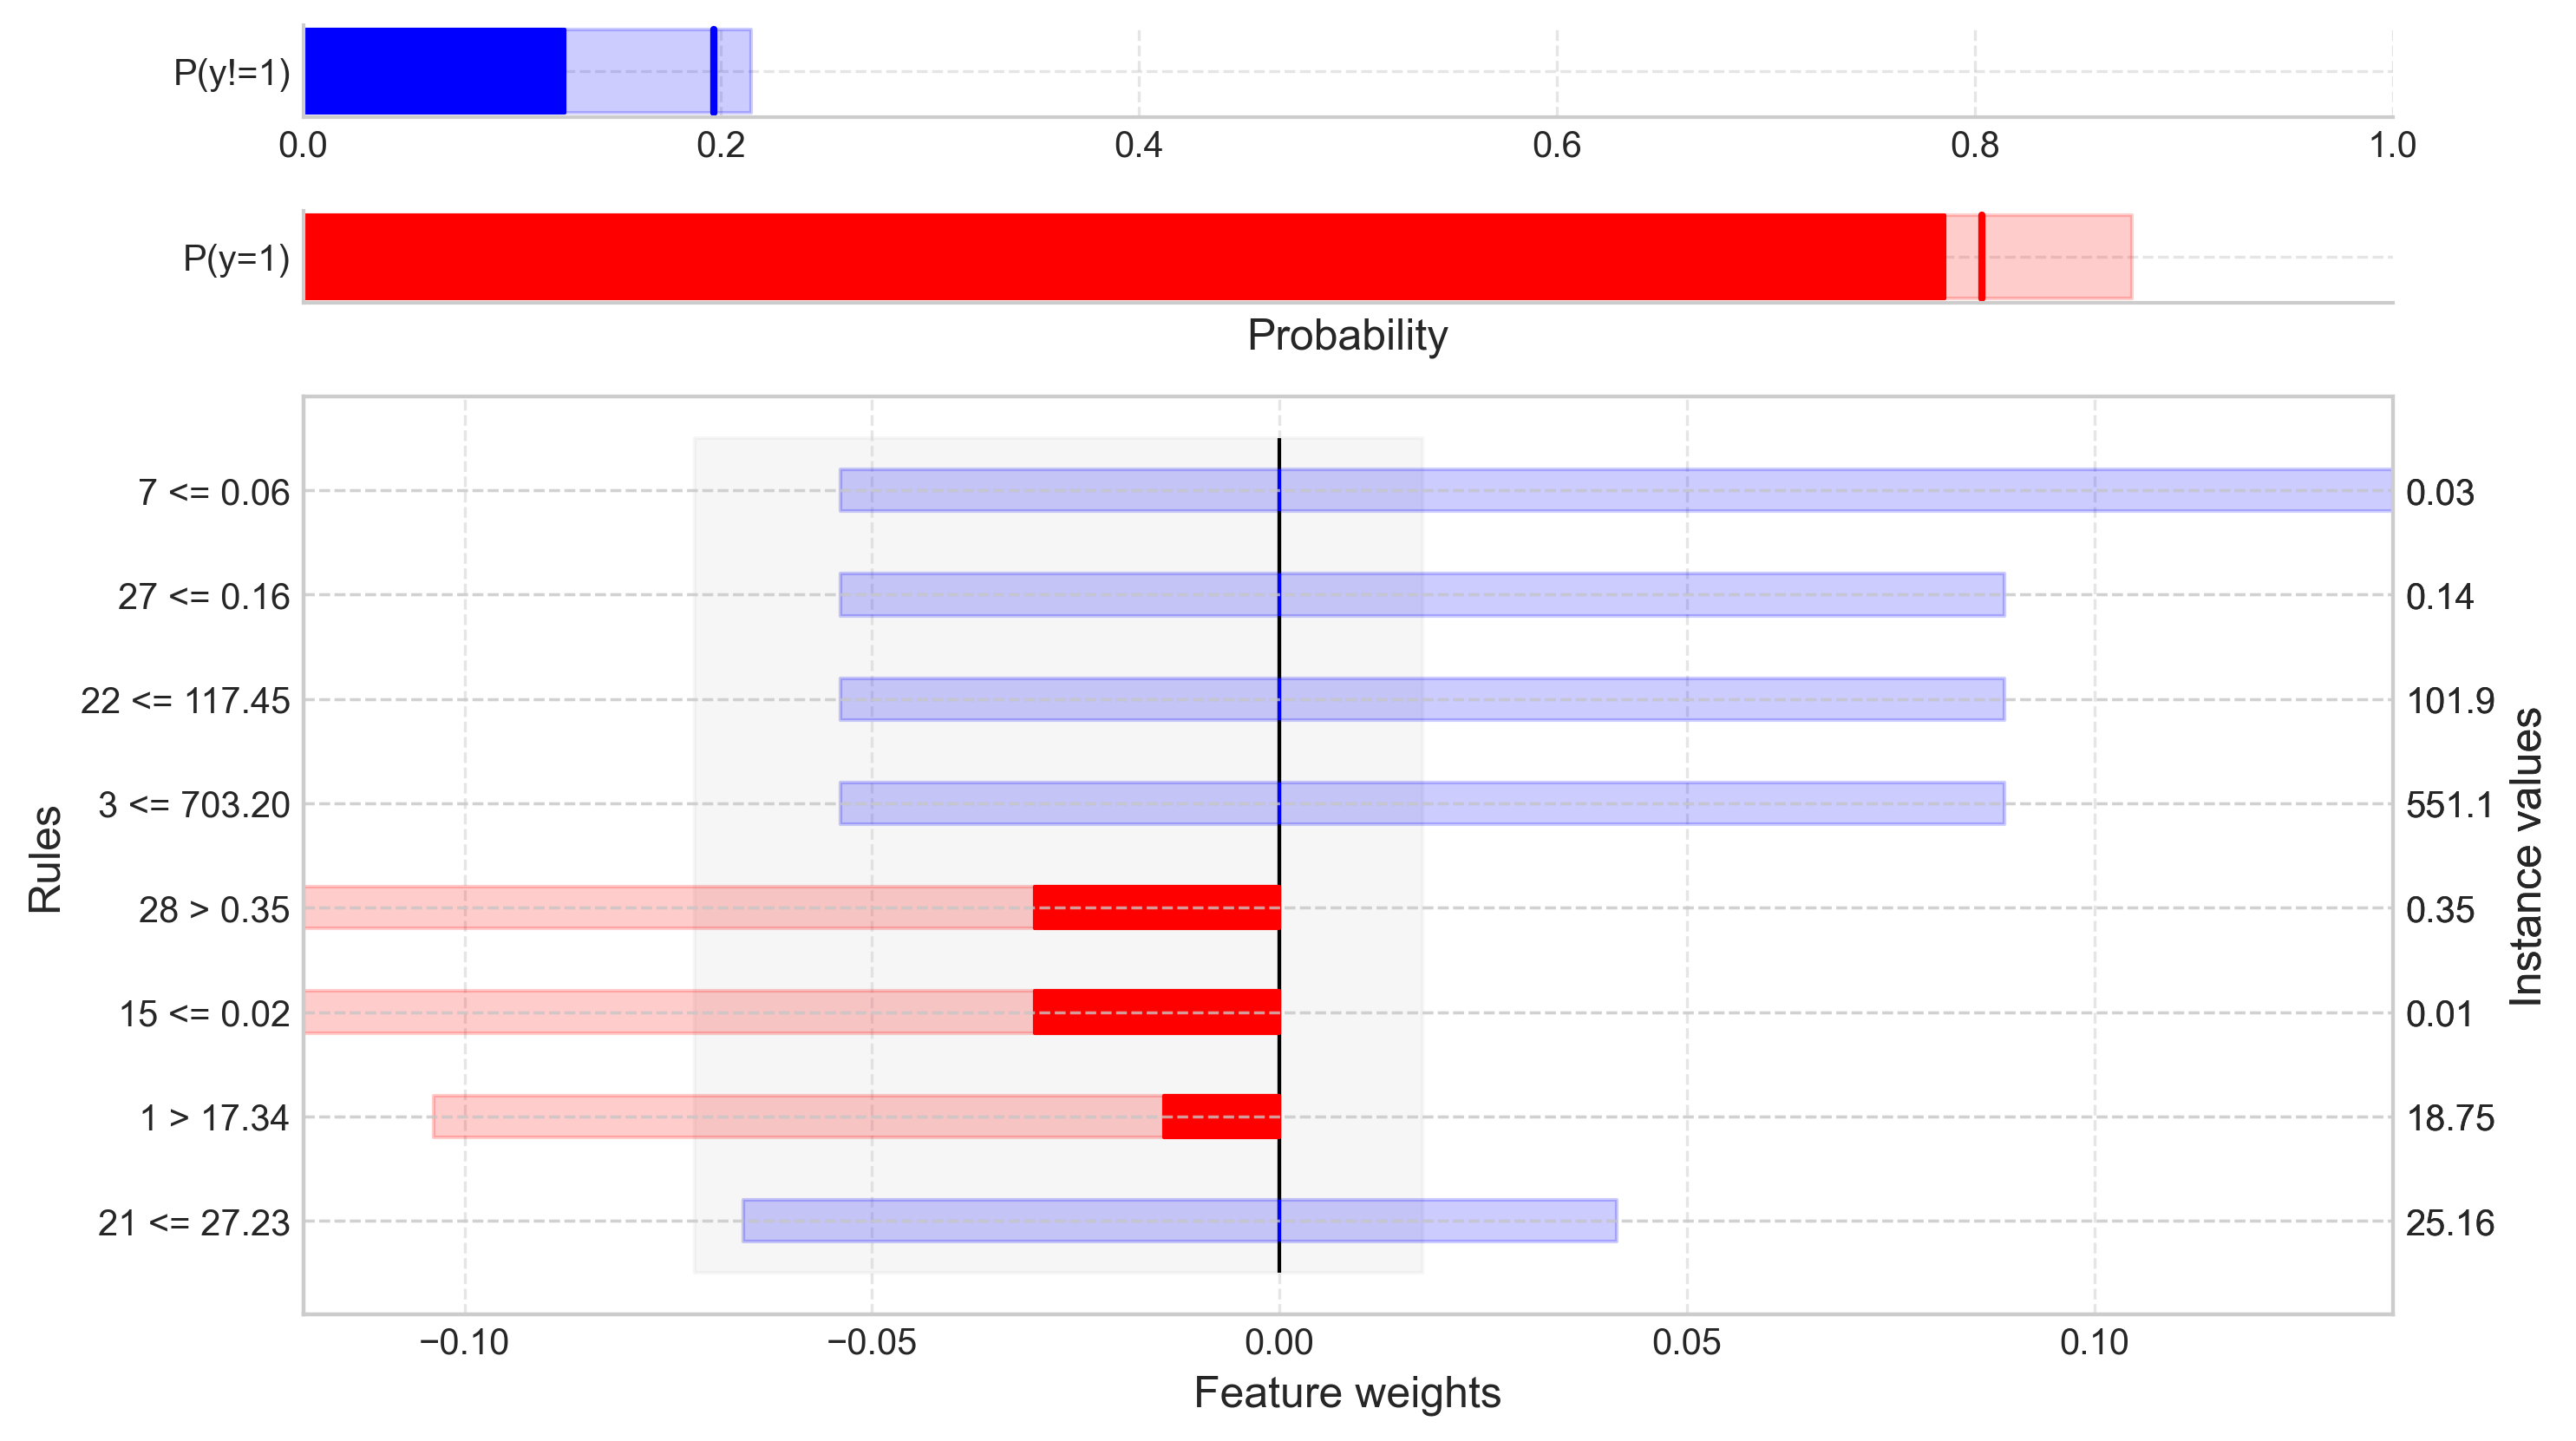

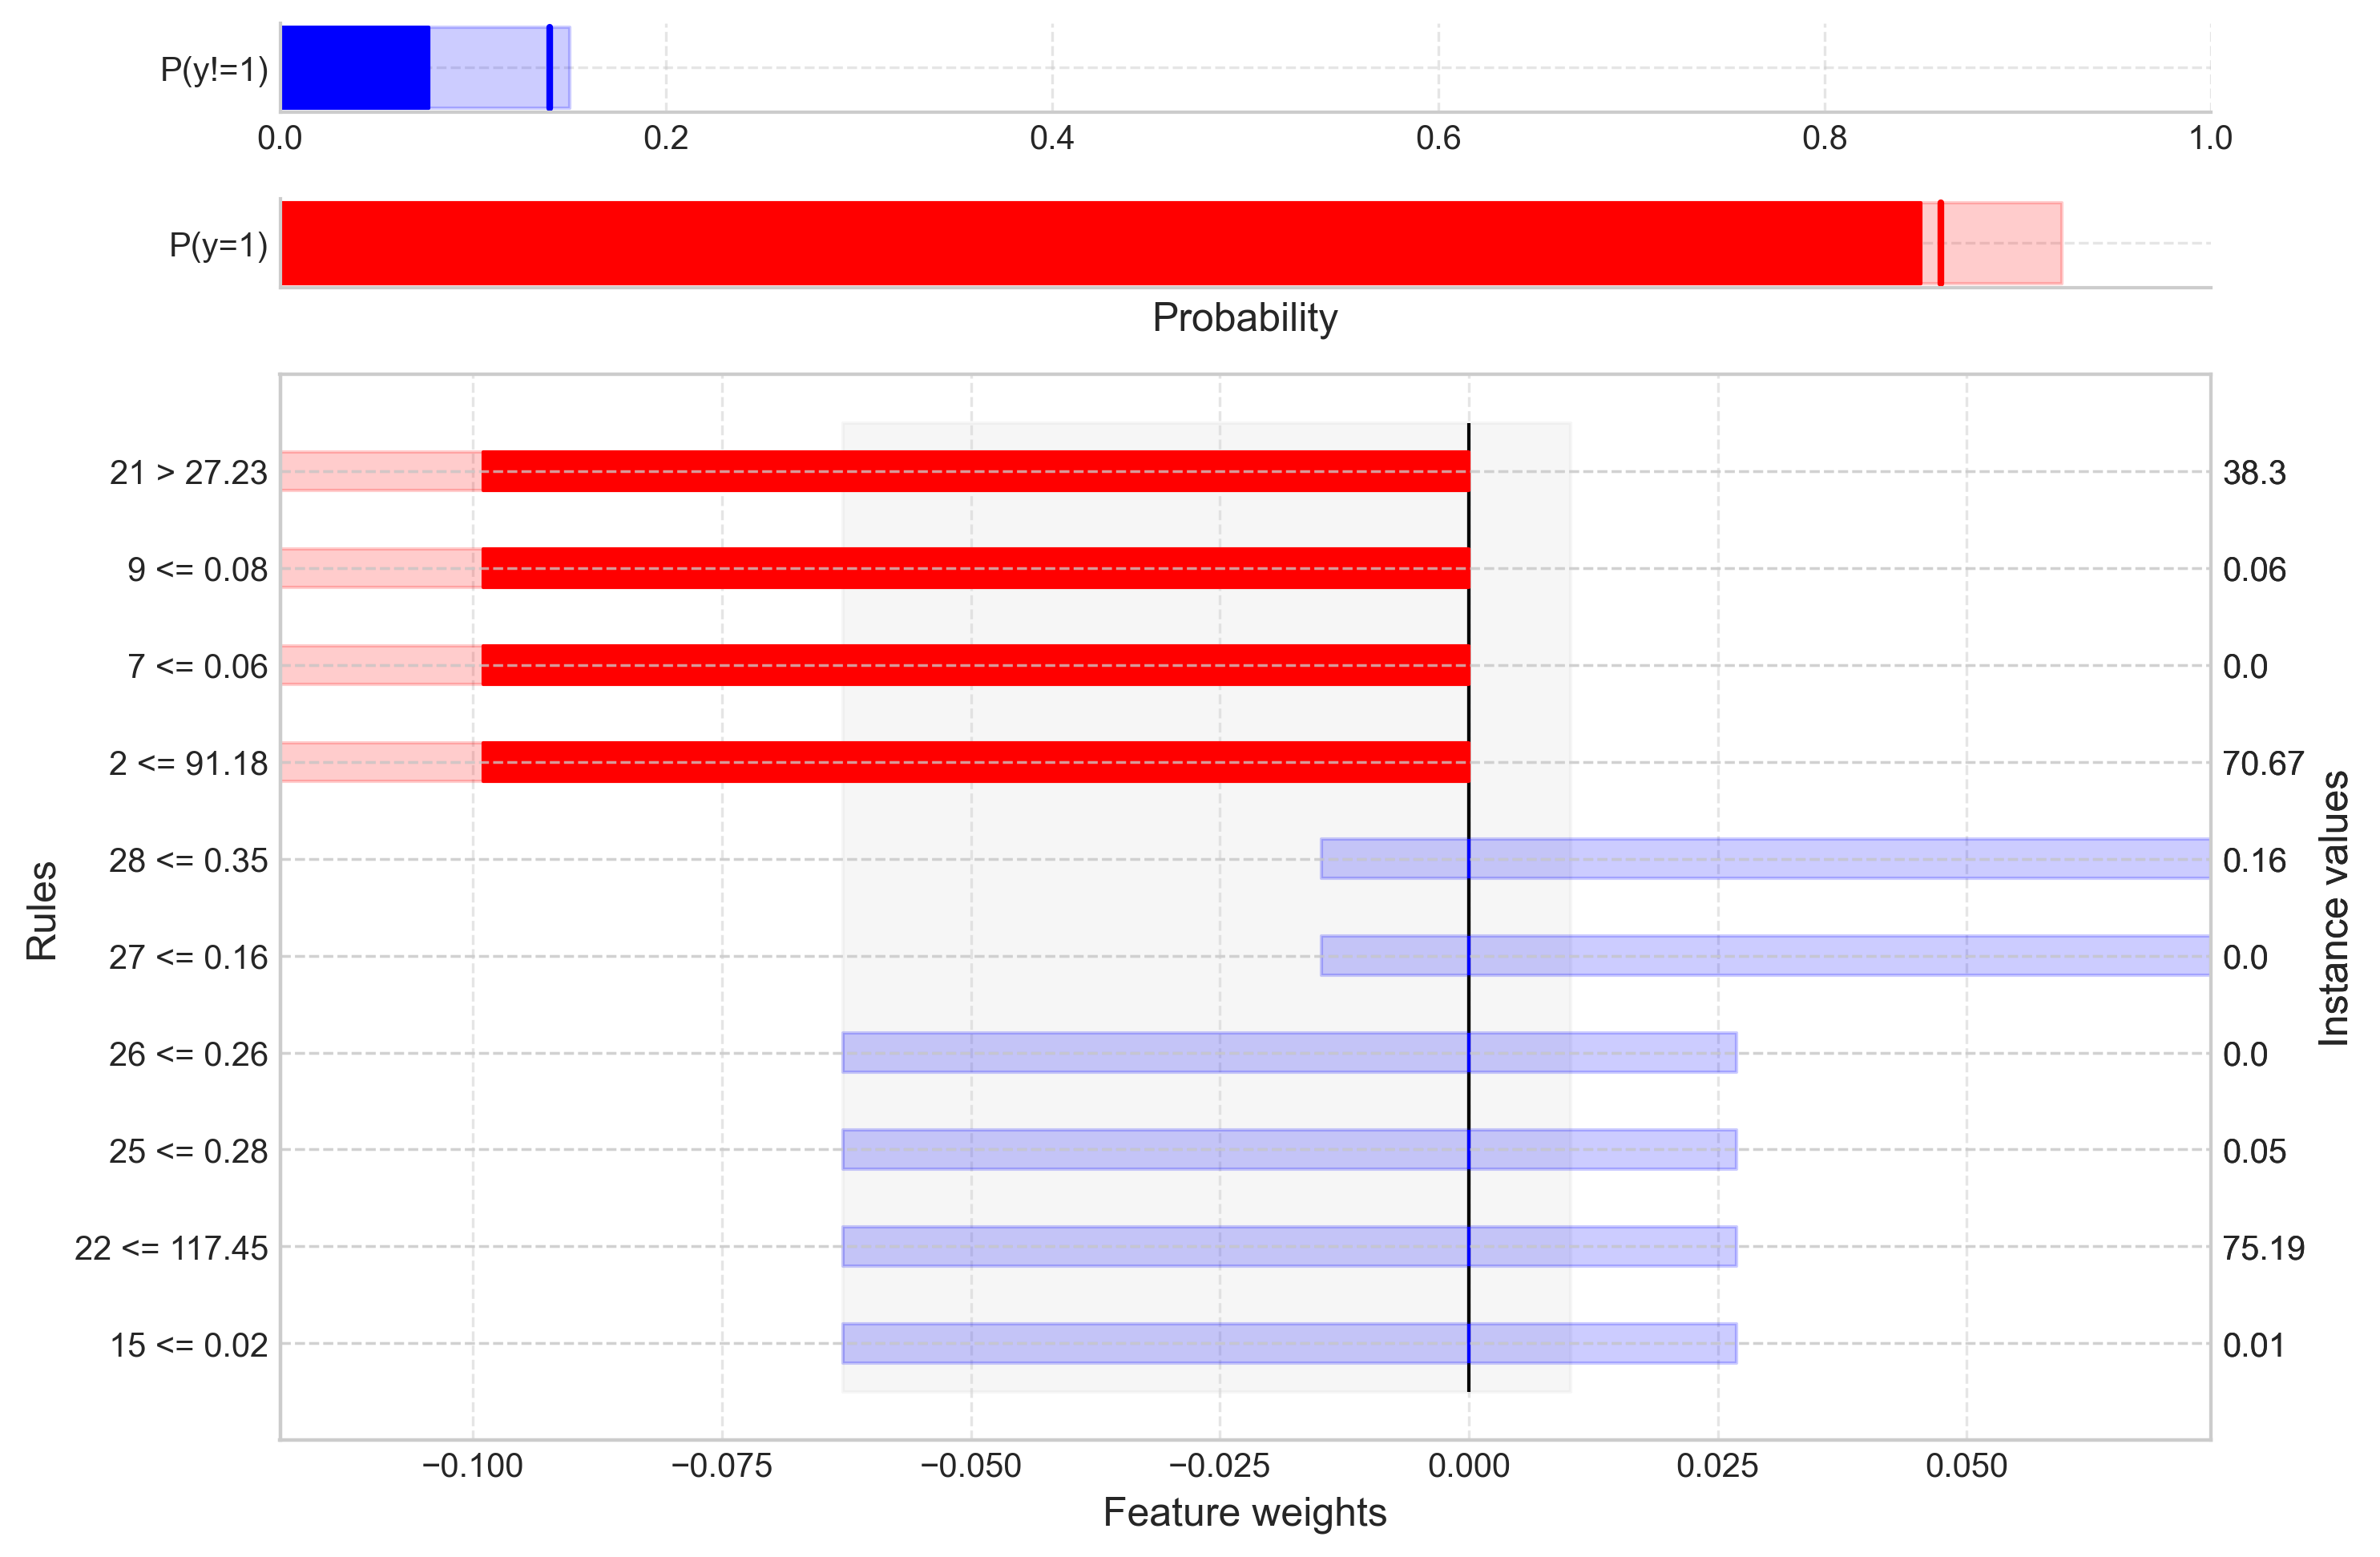

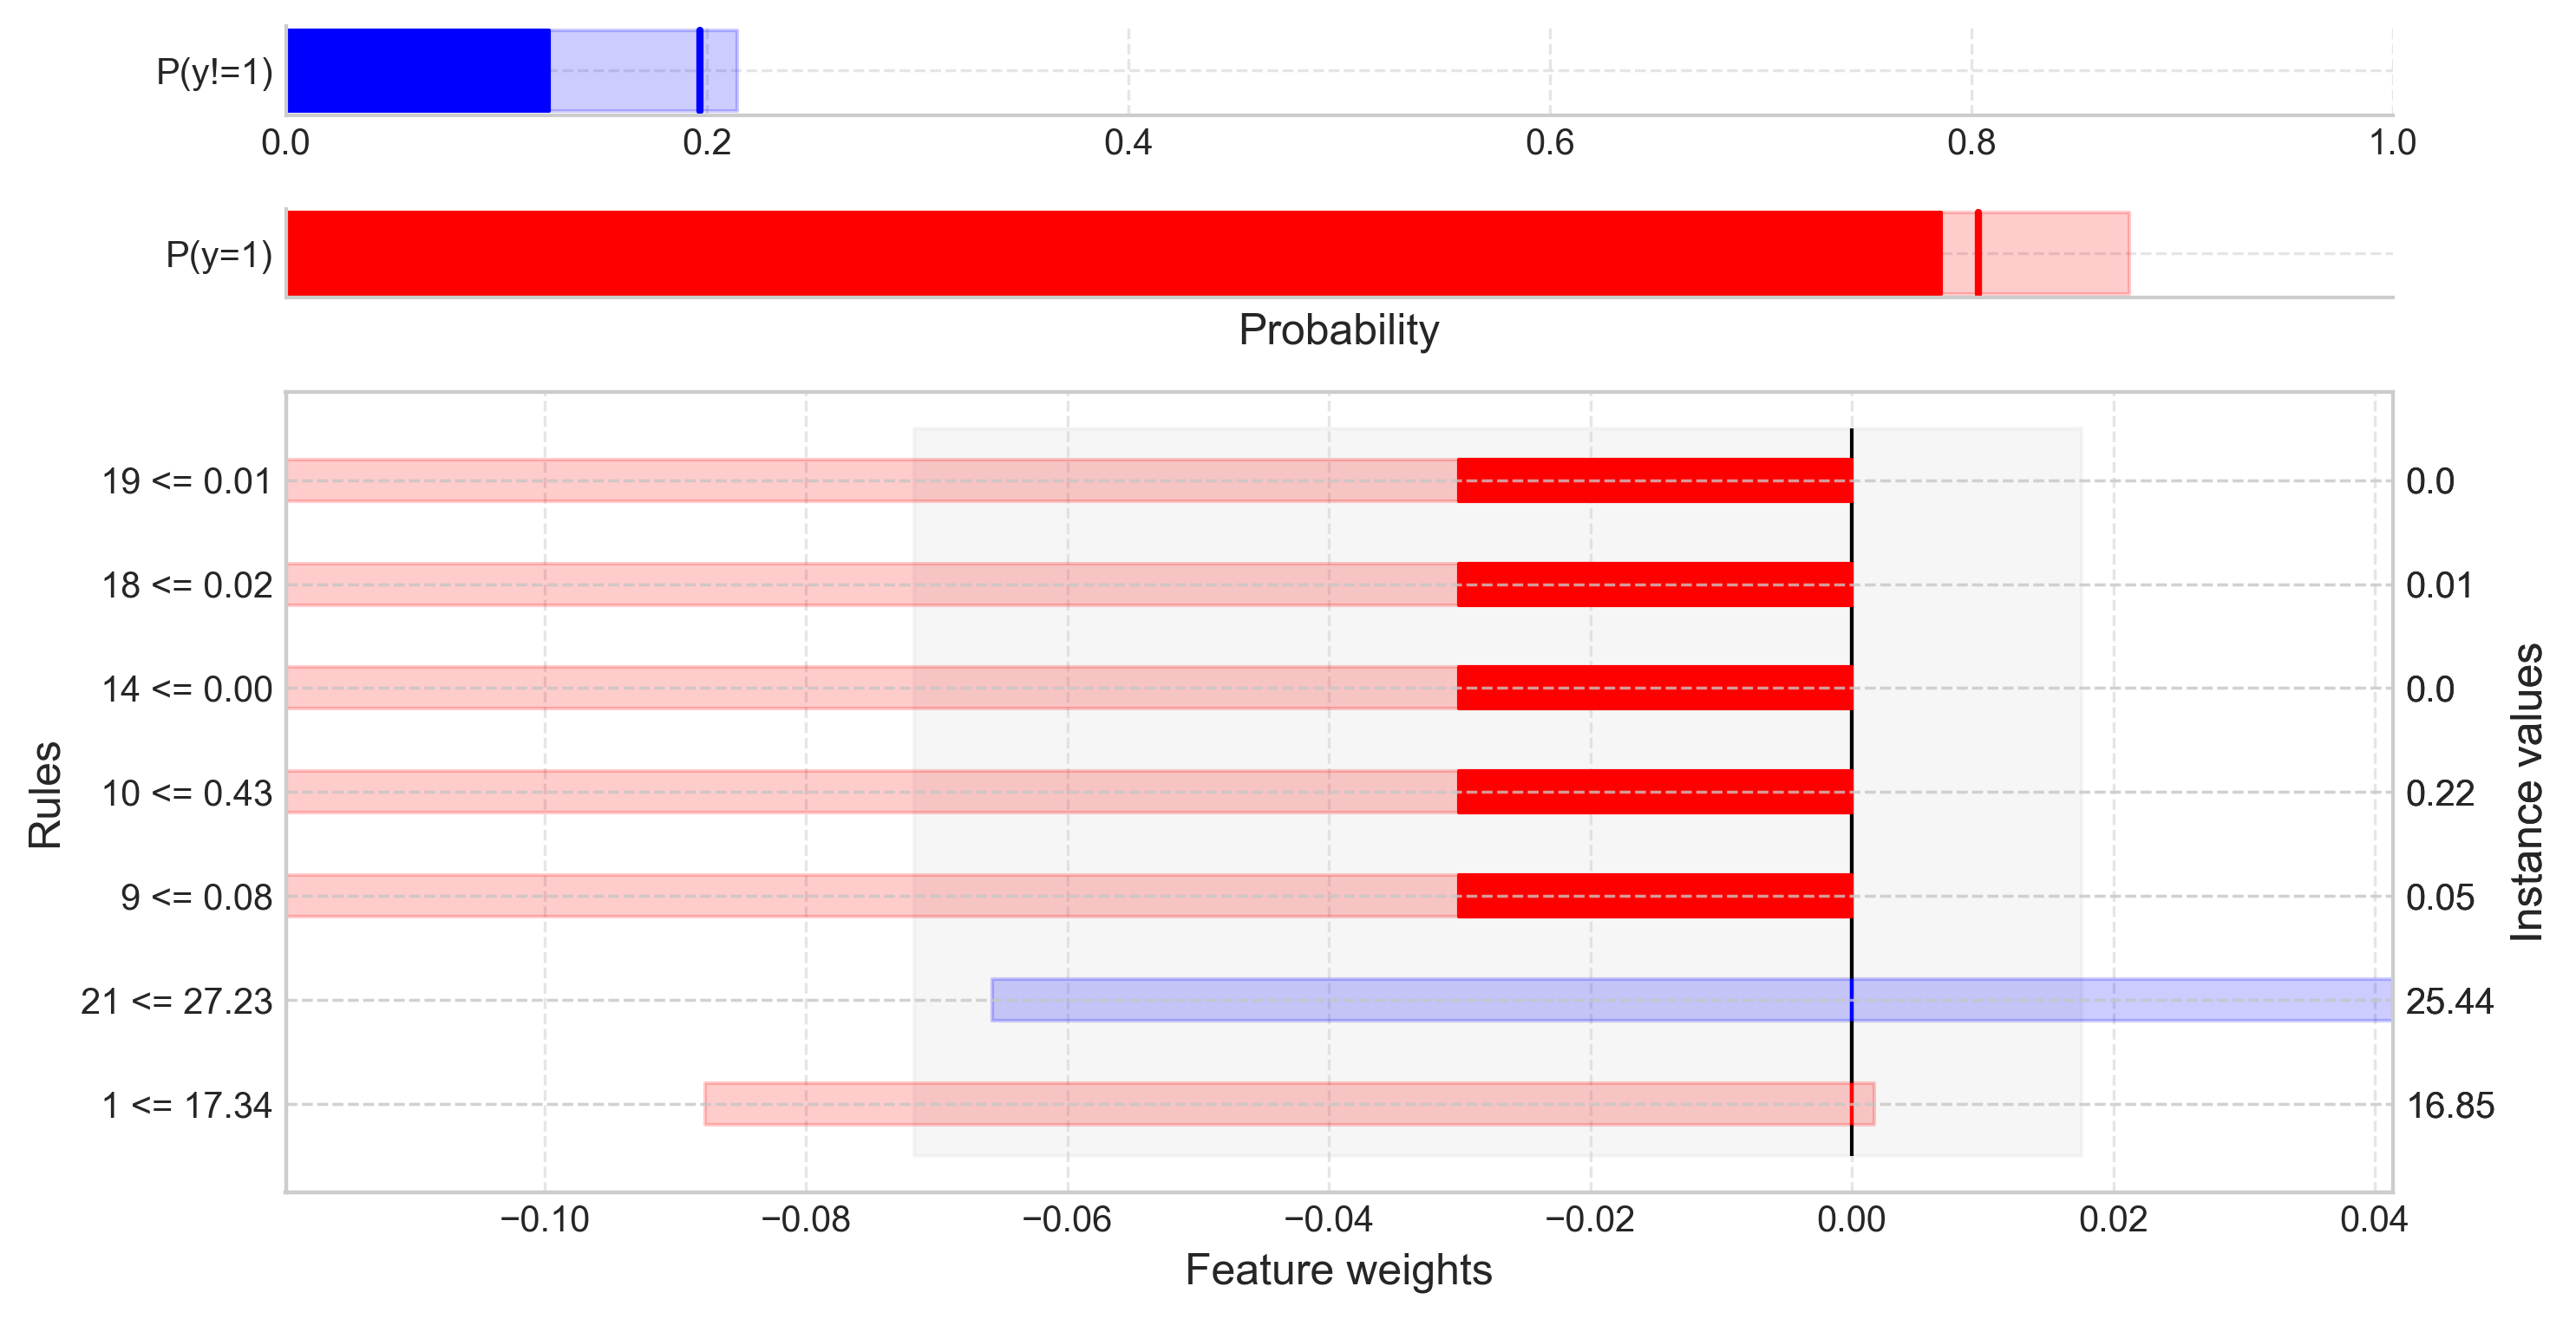

In [17]:
# Plot explanation for a rejected instance (if any)
rejected_indices = [i for i, rej in enumerate(reject_predictions[0]) if rej]
if rejected_indices:
    explanations = ce.explain_factual(X_test[rejected_indices])
    explanations.plot(uncertainty=True)
else:
    print("No rejected instances in this sample.")